## **术语解释：**

* **盲测试 (blind test)**：一种评估模型泛化能力的方法，在测试过程中模型看不到测试数据，需要完全依靠自身学习到的知识进行预测。
* **F11A 井**：被选作盲测试的井，其测井数据不会用于训练模型，而是用来评估模型的预测能力。


**使用 F11A 井作为`blind test well`盲测试井，预测其他井的测井数据。**


## 导入库 和 notebook 魔法命令

- seaborn 基于 matplotlib 构建的高级绘图库。
- mpl_toolkits.axes_grid1.axes_divider 用于创建子图布局。
- matplotlib.colors.ListedColormap 用于创建自定义颜色映射。

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import ListedColormap

%matplotlib inline 
pd.set_option('display.max_rows', 100)
pd.set_option('mode.chained_assignment',None)
mpl.rcParams['figure.dpi'] = 150

读取、删除列、删除空数据和处理异常值。

* **删除不需要的列：** 去除了 `RACEHM`、`RACELM`、`Unnamed: 0`、`KLOGV` 列，因为这些列可能与后续分析无关。
* **删除数据不完整的井：** 去除了 `Well_F19SR`、`Well_F19BT2`、`Well_F11` 这三个井，因为它们可能包含缺失值或异常数据，会影响后续分析的准确性。
* **处理异常值：** 将所有无限值 (`-999` 和 `-999.25`) 替换为 `NaN` (非数值)，方便后续数据清理和建模。
* **打印数据信息摘要：** 使用 `dframe.info()` 函数打印 DataFrame 的信息摘要，包括列名、数据类型、非空值个数等信息，便于了解数据概况。

In [4]:
filename = 'log_data.csv'
dframe=pd.read_csv(filename)

In [6]:
dframe.columns

Index(['WELL_NAME', 'DEPTH', 'GR', 'BS', 'CALI', 'ROP', 'RHOB', 'NPHI',
       'RACEHM', 'RACELM', 'RM', 'RD', 'PEF', 'DT', 'DTS', 'VCARB', 'VSH',
       'PHIF', 'SW', 'KLOGH', 'KLOGV', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'],
      dtype='object')

In [7]:

# 删除 DataFrame dframe 中不需要的列
dframe.drop(['RACEHM', 'RACELM', 'KLOGV'], axis=1, inplace=True)

# `Take out`删除数据不完整的井 `wells with incomplete data`
dframe = dframe[dframe['WELL_NAME'] != 'Well_F19SR']
dframe = dframe[dframe['WELL_NAME'] != 'Well_F19BT2']
dframe = dframe[dframe['WELL_NAME'] != 'Well_F11']
# 将所有`all infinity`无穷大值`replacing`替换为 NaN (非数值)
dframe.replace(['-999', -999.25], np.nan, inplace = True)

In [8]:
print(dframe.info())

<class 'pandas.core.frame.DataFrame'>
Index: 348110 entries, 0 to 359591
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  348110 non-null  object 
 1   DEPTH      348110 non-null  float64
 2   GR         345801 non-null  float64
 3   BS         216145 non-null  float64
 4   CALI       136306 non-null  float64
 5   ROP        213079 non-null  float64
 6   RHOB       160609 non-null  float64
 7   NPHI       143927 non-null  float64
 8   RM         309323 non-null  float64
 9   RD         272719 non-null  float64
 10  PEF        137966 non-null  float64
 11  DT         108671 non-null  float64
 12  DTS        54169 non-null   float64
 13  VCARB      28526 non-null   float64
 14  VSH        109865 non-null  float64
 15  PHIF       81502 non-null   float64
 16  SW         81517 non-null   float64
 17  KLOGH      87105 non-null   float64
 18  SAND_FLAG  88822 non-null   float64
 19  CARB_FLAG  64208 non-null   

## 机器学习

- 函数 apply_filter 使用中值滤波器对数据进行预处理，去除噪声。保留信号的相对幅度。
- 函数 outlier_removal 使用指定的异常检测方法检测并移除数据中的异常值。

- from sklearn.svm import OneClassSVM：导入用于单类支持向量机的库。
- from sklearn.covariance import EllipticEnvelope：导入用于椭圆包络异常检测的库。
- from sklearn.ensemble import IsolationForest：导入用于孤立森林异常检测的库。
- from sklearn.neighbors import LocalOutlierFactor：导入用于局部异常因子异常检测的库。
- from scipy.ndimage import median_filter：导入用于中值滤波的库

准确翻译和理解：

**1. 中值滤波预处理特征 (median filter to preprocess the features, remove the noise, preserve the relative magnitude of the signals)**

* **翻译：** 使用中值滤波器对特征进行预处理，去除噪声，保留信号的相对幅度。
* **理解：** 中值滤波器是一种非线性滤波器，用于抑制图像或信号中的噪声。它通过替换每个像素/数据点周围的邻域中位值来实现，可以去除椒盐噪声和脉冲噪声等。
* **应用：** 常用于图像处理、信号处理等领域，例如去除图像中的噪声、平滑信号等。

**2. 异常值占比参数 (major parameter percentage of outlier present with parameter contamination, nu : 6 %)**

* **翻译：** 异常值占比参数，污染率参数为 6%。
* **理解：** 
    * 污染率 (`contamination`) 是一个参数，表示预期在数据集中存在的异常值比例。
    * 在一些异常检测算法中，例如 One-Class SVM，需要预先设定污染率，算法会根据该参数尝试识别出与整体数据不同的异常值。
    * 本例中，污染率设置为 6%，表示算法会尝试识别出占总数据 6% 的异常值。
* **注意：** 污染率的设定需要根据实际情况和数据分布进行选择，并非所有情况下 6% 都一定是合适的数值。

**3. 可比较的异常检测方法 (define outlier/anomaly detection methods to be compared)**

* **翻译：** 定义要比较的异常检测方法。
* **理解：** 这段代码定义了多种可以用于检测异常值的算法，例如椭圆包络、单类支持向量机、孤立森林和局部异常因子等。
* **应用：** 根据数据特性和需求，可以选择合适的异常检测算法进行应用。例如，对于高维数据，孤立森林算法可能表现良好；对于簇状分布的数据，局部异常因子算法可能更适合。

**4. 逐个特征检测异常 (detect anomaly for each features)**

* **翻译：** 逐个特征检测异常。
* **理解：** 这段代码针对每个特征单独进行异常检测，即分别对每个列的数据进行分析。
* **应用：** 适用于特征之间独立或差异较大的情况。

**5. 标记内点和异常点 (Automatic anomaly flagging on whole data sample with inliers labeled as 1 and outliers labeled as -1)**

* **翻译：** 对整个数据集自动标记内点和异常点，内点标记为 1，异常点标记为 -1。
* **理解：** 这段代码使用异常检测算法对所有数据进行分析，并根据算法的输出结果将数据点标记为内点 (1) 或异常点 (-1)。
* **应用：** 用于后续处理异常值，例如去除异常值或进一步分析异常值的原因。

**6. 移除异常值 (remove anomaly)**

* **翻译：** 移除异常值。
* **理解：** 这段代码根据前面检测到的异常点标记，将被标记为异常值 (-1) 的数据点从原始数据集中移除。
* **应用：** 用于剔除可能影响后续分析结果的异常值，提高模型的准确性。


In [10]:
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy.ndimage import median_filter

#%% **`Remove`移除`noise data`数据噪声**

def apply_filter(df, name=''):
    """
    使用中值滤波预处理特征，去除噪声，保留信号的相对幅度。
    
    Args:
        df: 需要预处理的 DataFrame。
        name: 可选参数，用于标识处理过程名称。

    Returns:
        经过预处理后的 DataFrame。
    """
    
    # `median filter`中值滤波器`preprocess the features`预处理特征，`remove the noise`去除噪声，`preserve`保留`signals`信号的`relative magnitude`相对幅度
    # 复制 DataFrame 以避免修改原始数据
    x=df   #.drop(['WELL_NAME', 'DEPTH'], axis = 1)
    
    # 打印处理前的数据描述性统计信息
    print('Before applying noise-filter [%s]\n' % name, x.describe())
    
    # 逐列应用中值滤波器去除噪声
    for i in x.keys():
        x[i]=median_filter(df[i].values,size=20,mode='nearest')

    #for item in df.keys():
    #    if item not in x.keys():
    #        x[item]=df[item]
    #x = x.reindex(columns=df.columns.tolist())
    df=x
    
    # 打印处理后的数据描述性统计信息
    print('After applying noise-filter [%s]\n' % name, x.describe())
    return df


#%% **移除异常值** Remove outliers
def outlier_removal(df, ind=-1):
    """
    检测并移除数据集中的异常值。

    Args:
        df: 需要处理的 DataFrame。
        ind: 可选参数，用于指定要分析的列数 (默认分析所有列)。

    Returns:
        经过异常值处理后的 DataFrame。
    """
    
    log_header = df.columns.tolist()

    # 打印处理前的数据描述性统计信息 (剔除 'WELL_NAME' 和 'DEPTH' 列)
    print('Before anomaly treatment\n',df.drop(['WELL_NAME', 'DEPTH'], axis=1).describe())

    # 定义异常检测方法和污染率参数
    # 异常值占比参数，污染率参数为 6% `major parameter percentage of outlier present with parameter contamination, nu : 6 %`
    outliers_frac = 0.06 # 异常值比例 (6%)
    # 定义要`compared`比较的`outlier/anomaly`异常`detection methods`检测方法。
    anomaly_algorithms = [('Robust covariance', EllipticEnvelope(contamination=outliers_frac)),
                      ('One-Class SVM', OneClassSVM(nu=outliers_frac, kernel="rbf", gamma='scale')),
                      ('Isolation Forest', IsolationForest(n_estimators=100, max_samples='auto',
                                                           contamination=outliers_frac, random_state=42)),
                      ('Local Outlier Factor', LocalOutlierFactor(n_neighbors=35, contamination=outliers_frac))]
    
    # 循环交互式选择异常检测方法
    while True:
        method=int(input('Select the outlier detection method\n Enter # 0-EllipticEnvelope;'
                         '1-OneClassSVM; 2-IsolationForest; 3-LocalOutlierFactor: '))
        each_feature=input('Do you want outlier detection for each feature, "yes" or "no"?: ')
        each_feature = False if each_feature.lower() == 'no' else True
        
        if method in np.array([0, 1, 2, 3]):
            print('Method = ', method, ': ', anomaly_algorithms[method][0])
            break
        elif method=='':
            break
        else:
            print('Method "%s" selected can not be found, try again' % method)
            
    # method = 2  # 0-EllipticEnvelope; 1-OneClassSVM; 2-IsolationForest; 3-LocalOutlierFactor
    
    # 初始化用于计数异常值的数组
    counter = np.zeros(df.shape[0])
    
    # 创建绘图窗口
    fig = plt.figure(figsize=(12.0, 8.0))
    fig.subplots_adjust(hspace=0.4, wspace=0.6)
    
    # 选择是否逐个特征进行异常检测
    if each_feature:
        # 逐个特征检测异常 (detect anomaly for each features)
        # 逐个特征进行异常检测
        for i, item in enumerate(log_header[2:ind]):
            # 对`whole data sample`整个数据集`Automatic`自动`flagging`标记内点和`anomaly`异常点，`inliers labeled`内点标记为 1，`outliers labeled`异常点标记为 -1。
            # 拟合异常检测模型并预测异常值
            anomaly = anomaly_algorithms[method][1].fit_predict(df[[item]])
            plt.subplot(151+i)
            
            # 绘制原始数据和异常值散点图
            log_scatter(df[item], df.DEPTH, label='original', marker='o')
            log_scatter(df[item][anomaly==-1], df.DEPTH[anomaly==-1],
                        x_label=item, y_label='DEPTH', title=item, marker='^', label='outliers')
            
            # 打印检测到的异常值数量
            print('\nNumber of anomalies detected for', item, '=', -sum(anomaly[anomaly==-1]),'out of', anomaly.shape[0])
            counter +=anomaly
            
        # 移除`anomaly`异常值
        if method in [0, 1, 2, 3]:
            df = df[counter==df.shape[1]-2+ind]
            print('\nNumber of dataset after anomalies removal =',df.shape[0])
            
    else:
        # 对所有特征联合进行异常检测
        anomaly = anomaly_algorithms[method][1].fit_predict(df.drop(['WELL_NAME', 'DEPTH', 'VSH'], axis=1))
        
        # 逐个特征绘制原始数据和异常值散点图
        for i, item in enumerate(log_header[2:ind]):
            plt.subplot(151+i)
            log_scatter(df[item], df.DEPTH, label='original', marker='o')
            log_scatter(df[item][anomaly==-1], df.DEPTH[anomaly==-1],
                        x_label=item, y_label='DEPTH', title=item, marker='^', label='outliers')
            
            # 打印检测到的异常值数量
            print('Number of anomalies = ', -sum(anomaly[anomaly==-1]),'out of', anomaly.shape[0])
            
        # remove anomaly
        # 移除异常值
        if method in [0, 1, 2, 3]:
            df = df[anomaly==1]
            print('Number of dataset after anomalies removal =',df.shape[0])

    # 打印处理后的数据描述性统计信息 (剔除 'WELL_NAME' 和 'DEPTH' 列)        
    print('After anomaly treatment\n',df.drop(['WELL_NAME', 'DEPTH'], axis=1).describe())
    return df

打印信息分析：

**1. `print('Before applying noise-filter [%s]\n' % name, x.describe())`**

* **翻译：** 在应用降噪滤波之前，打印数据帧 `x` 的描述性统计信息 (名称 `name` 可选)。
* **解释：** 这段代码打印数据在应用中值滤波器之前的一些基本统计信息，例如均值、标准差、最小值、最大值等，可以帮助了解数据分布情况。

**2. `print('After applying noise-filter [%s]\n' % name, x.describe())`**

* **翻译：** 在应用降噪滤波之后，打印数据帧 `x` 的描述性统计信息 (名称 `name` 可选)。
* **解释：** 这段代码与上段类似，打印数据在应用中值滤波器之后的一些基本统计信息，可以对比观察滤波前后数据的变化。

**3. `print('Before anomaly treatment\n',df.drop(['WELL_NAME', 'DEPTH'], axis=1).describe())`**

* **翻译：** 在进行异常处理之前，打印剔除 `'WELL_NAME'` 和 `'DEPTH'` 列后的数据帧 `df` 的描述性统计信息。
* **解释：** 这段代码在进行异常检测之前，先剔除无关的列 (井名和深度)，然后打印剩余数据的统计信息，以便于后续分析。

**4. `print('method = ', method, ': ', anomaly_algorithms[method][0])`**

* **翻译：** 打印选定的异常检测方法名称。
* **解释：** 用户通过输入编号选择了特定的异常检测方法 (例如 0 代表 EllipticEnvelope)，这行代码会打印该方法的名称。

**5. `print('\nNumber of anomalies detected for', item, '=', -sum(anomaly[anomaly==-1]),'out of', anomaly.shape[0])`**

* **翻译：** 打印针对特征 `item` 检测到的异常值数量。
* **解释：** 这段代码针对每个特征单独进行异常检测，并打印检测到的异常值数量。`-sum(anomaly[anomaly==-1])` 计算被标记为异常值 (anomaly 为 -1) 的个数，除以 `anomaly.shape[0]` 得到异常值占总数据的比例。

**6. `print('Number of anomalies = ', -sum(anomaly[anomaly==-1]),'out of', anomaly.shape[0])`**

* **翻译：** 打印针对所有特征联合检测到的异常值数量。
* **解释：** 这段代码对所有特征联合进行异常检测，并打印检测到的异常值数量。计算方式与上段类似。

**7. `print('Number of dataset after anomalies removal =',df.shape[0])`**

* **翻译：** 打印移除异常值后的数据集大小。
* **解释：** 这段代码根据前面检测到的异常点，将异常值从原始数据集中移除，并打印移除后的数据集大小。

**8. `print('After anomaly treatment\n',df.drop(['WELL_NAME', 'DEPTH'], axis=1).describe())`**

* **翻译：** 在进行异常处理之后，打印剔除 `'WELL_NAME'` 和 `'DEPTH'` 列后的数据帧 `df` 的描述性统计信息。
* **解释：** 这段代码与处理之前类似，在移除异常值后，打印剩余数据的统计信息，可以观察异常值对数据分布的影响。


### 聚类

**函数 `data_cluster(df, name='', ncomp=0, nclus=0)`:**

**1. 特征降维 (feature reduction technique PCA)**

- `pca = PCA()`：创建一个 PCA 对象，用于进行主成分分析。
- `pca.fit(df)`：拟合 PCA 转换器，学习数据分布。
- `print(pca.explained_variance_ratio_)`：打印每个主成分的方差贡献率。
- `print(pca.explained_variance_ratio_.cumsum())`：打印累积的方差贡献率。
- `pca = PCA(n_components=ncomp)`：设置保留的主成分个数为 `ncomp`，创建新的 PCA 对象。
- `df_pca = pca.fit_transform(df)`：使用 PCA 将数据转换为降维后的空间。


**2. 肘部法 (Elbow method)**

- `wcss, maxit = [], 11`：初始化空列表 `wcss` 存储 WCSS (Within-Cluster Sum of Squares) 值，`maxit` 设置最大簇数为 11。
- `nClusters=range(1,maxit)`：创建一个包含从 1 到 `maxit-1` 的范围，代表可能的簇数。
- `for i in nClusters:`：遍历每个可能的簇数。
    - `kmeans = KMeans(n_clusters=i, init='k-means++', n_init=20, max_iter=500, random_state=40)`：创建 KMeans 聚类对象，设置簇数为 `i`，使用 k-means++ 算法初始化质心，运行 20 次初始化，最大迭代次数为 500，随机种子为 40。
    - `kmeans.fit(df_pca)`：用 KMeans 模型聚类降维后的数据。
    - `wcss.append(kmeans.inertia_)`: 将 WCSS 值添加到列表 `wcss` 中。
- 绘制肘部曲线：
    - `plt.figure()`: 创建一个新的绘图窗口。
    - `plt.plot(nClusters, wcss,'^-')`: 使用三角形标记 ('^-') 绘制 WCSS 值和簇数的关系图。
    - `plt.axvline(x = nclus-1, linewidth = 1, color = 'red')`: 用红色虚线 (linewidth = 1) 标记用户指定的簇数 (nclus-1)。
    - `plt.axvline(x = nclus, linewidth = 2, color = 'red')`: 用红色实线 (linewidth = 2) 标记用户指定的簇数 (nclus)。
    - `plt.axvline(x = nclus+1, linewidth = 1, color = 'red')`: 用红色虚线 (linewidth = 1) 标记用户指定的簇数 (nclus+1)。
    - 设置图表标题、坐标轴标签和刻度。
    - `plt.show()`: 显示图表。

**3. 轮廓系数法 (Silhouette method)**

- `silhouette_score_values=[]`: 初始化空列表 `silhouette_score_values` 存储轮廓系数得分。
- `for i in nClusters:`：遍历每个可能的簇数。
    - `if i != 1:`：跳过单簇情况 (i=1)。
        - `kmeans=KMeans(...)`: 创建 KMeans 聚类对象，参数与肘部法相同。
        - `kmeans.fit(df)`：用 KMeans 模型聚类原始数据 (未降维)。
        - `labels= kmeans.predict(df)`：获取聚类标签。
        - `silhouette_avg=silhouette_score(df,labels ,metric='euclidean', sample_size=None, random_state=None)`：计算轮廓系数得分，使用欧氏距离度量 (metric='euclidean')。
        - 将轮廓系数得分添加到 `silhouette_score_values` 列表并打印。
    - `else:`：单簇情况，轮廓系数得分为 0。
- `Optimal_Number=nClusters[silhouette_score_values.index(max(silhouette_score_values))]`: 找到轮廓系数得分最高的簇数，并将其存储在 `Optimal_Number` 中。
- `print ('Optimal number of components is: %s' % Optimal_Number)`：打印最优簇数。

**绘制轮廓系数得分图：**

- `plt.figure()`: 创建一个新的绘图窗口。
- `plt.plot(nClusters[1:], silhouette_score_values[1:],'o-')`: 使用圆形标记 ('o-') 绘制轮廓系数得分和簇数的关系图，从第二个簇开始 (nClusters[1:])。
- `plt.title("Silhouette score values vs Numbers of Clusters ")`: 设置图表标题。
- `plt.xlabel('Number of Clusters')`: 设置 X 轴标签。
- `plt.ylabel('Silhouette score values')`: 设置 Y 轴标签。
- `plt.xticks(np.arange(0, maxit, step=1))`: 设置 X 轴刻度。
- `plt.show()`: 显示图表。

**4. KMeans 聚类**

- `kmeans = KMeans(n_clusters=nclus, init='k-means++', n_init=20, max_iter=300, random_state=0)`: 创建 KMeans 聚类对象，设置簇数为 `nclus`，使用 k-means++ 算法初始化质心，运行 20 次初始化，最大迭代次数为 300，随机种子为 0。
- `Y_kmeans = kmeans.fit_predict(df_pca)`: 使用 KMeans 模型聚类降维后的数据，并返回聚类标签。

**5. 将聚类结果添加到数据帧**

- `df['%s' % name]=kmeans.labels_`: 将聚类标签添加到数据帧 `df` 中，列名为 `name`。

**6. 返回数据帧**

- `return df`: 返回包含聚类结果的数据帧。

**注意:**

- 该函数默认使用 PCA 进行特征降维，但也可以直接使用原始数据进行聚类 (将 `ncomp` 设置为 0)。
- 函数中使用了肘部法和轮廓系数法两种方法来确定最佳簇数，用户可以根据实际情况选择其中一种或两种方法结合使用。


In [11]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def data_cluster(df, name='', ncomp=0, nclus=0):
    # feature reduction technique PCA 
    pca = PCA()
    pca.fit(df)
    print(pca.explained_variance_ratio_)
    print(pca.explained_variance_ratio_.cumsum())
    pca = PCA(n_components=ncomp)
    df_pca = pca.fit_transform(df)
    
    # Elbow method
    wcss, maxit = [], 11
    nClusters=range(1,maxit)
    for i in nClusters:
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=20, max_iter=500, random_state=40)
        kmeans.fit(df_pca)
        wcss.append(kmeans.inertia_)
    plt.figure()
    plt.plot(nClusters, wcss,'^-')
    plt.axvline(x = nclus-1, linewidth = 1, color = 'red')
    plt.axvline(x = nclus, linewidth = 2, color = 'red')
    plt.axvline(x = nclus+1, linewidth = 1, color = 'red')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('wcss')
    plt.xticks(np.arange(0, maxit, step=1))
    plt.show()
    
    # Silhouette method
    silhouette_score_values=[]
    for i in nClusters:
        if i != 1:
            kmeans=KMeans(n_clusters=i,init='k-means++', n_init=10, max_iter=500,
                      tol=0.0001, verbose=0, random_state=40, copy_x=True)
            kmeans.fit(df)
            labels= kmeans.predict(df)
            silhouette_avg=silhouette_score(df,labels ,metric='euclidean', sample_size=None, random_state=None)
            silhouette_score_values.append(silhouette_avg)
            print('Number of Clusters: %s' % i, ', Silhouette score: %s' % silhouette_avg)
        else:
            silhouette_avg=0
            silhouette_score_values.append(silhouette_avg)       
    Optimal_Number=nClusters[silhouette_score_values.index(max(silhouette_score_values))]
    print ('Optimal number of components is: %s' % Optimal_Number)
    plt.figure()
    plt.plot(nClusters[1:], silhouette_score_values[1:],'o-')
    plt.title("Silhouette score values vs Numbers of Clusters ")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette score values')
    plt.xticks(np.arange(0, maxit, step=1))
    plt.show()     
    
    # fitting kmeans to dataset
    kmeans = KMeans(n_clusters=nclus, init='k-means++', n_init=20, max_iter=300, random_state=0)
    Y_kmeans = kmeans.fit_predict(df_pca)
    
    #cluster zone ids to VShale database
    df['%s' % name]=kmeans.labels_
    return df    

翻译和理解 `data_cluster` 函数中的注释、打印内容和绘图标签：

**1. 特征降维 (PCA)**

* **注释：** `# feature reduction technique PCA`: 该注释说明了 PCA 用于进行特征降维。
* **打印内容：**
    * `print(pca.explained_variance_ratio_)`: 打印每个主成分的方差贡献率，可以帮助理解哪些主成分保留了较多的原始数据的方差信息。
    * `print(pca.explained_variance_ratio_.cumsum())`: 打印累积的方差贡献率，可以帮助确定需要保留多少个主成分才能达到预期的信息保留率。
* **绘图：** 未提及绘图。

**2. 肘部法 (Elbow method)**

* **注释：** 未提及相关注释。
* **打印内容：** `print('Number of Clusters: %s' % i, ', Silhouette score: %s' % silhouette_avg)`: 
    * 循环遍历每个簇数时，打印当前簇数和对应的轮廓系数得分。
* **绘图：**
    * `plt.title('Elbow Method')`: 设置图表标题为 "Elbow Method"。
    * `plt.xlabel('Number of Clusters')`: 设置 X 轴标签为 "Number of Clusters"。
    * `plt.ylabel('wcss')`: 设置 Y 轴标签为 "wcss" (Within-Cluster Sum of Squares)。
    * `plt.xticks(np.arange(0, maxit, step=1))`: 设置 X 轴刻度为从 1 到 `maxit-1` 的范围，步长为 1。

**3. 轮廓系数法 (Silhouette method)**

* **注释：** 未提及相关注释。
* **打印内容：** `print ('Optimal number of components is: %s' % Optimal_Number)`: 打印根据轮廓系数法确定的最优簇数。
* **绘图：**
    * `plt.title("Silhouette score values vs Numbers of Clusters ")`: 设置图表标题为 "Silhouette score values vs Numbers of Clusters"。
    * `plt.xlabel('Number of Clusters')`: 设置 X 轴标签为 "Number of Clusters"。
    * `plt.ylabel('Silhouette score values')`: 设置 Y 轴标签为 "Silhouette score values"。
    * `plt.xticks(np.arange(0, maxit, step=1))`: 设置 X 轴刻度为从 1 到 `maxit-1` 的范围，步长为 1。

**5. 添加聚类结果**

* **注释：** `#cluster zone ids to VShale database`: 该注释说明将聚类标签添加到数据帧中，列名为 `name`。
* **打印内容：** 未提及打印内容。
* **绘图：** 未提及绘图。

**总体:**

该函数的主要部分为使用 PCA 进行特征降维，然后结合肘部法和轮廓系数法确定最佳簇数，最后使用 KMeans 模型进行聚类并添加到数据帧中。

函数 `data_cluster` 中打印的图表：

**1. 肘部法 (Elbow method)**

* **图表类型：** 折线图
* **X 轴：** 簇数 (Number of Clusters)
* **Y 轴：** WCSS (Within-Cluster Sum of Squares)
* **含义：** WCSS 代表了每个簇内样本点到其质心的平均距离平方和，该值越小说明簇内样本越紧密。
* **分析：** 随着簇数的增加，WCSS 会逐渐减小，因为每个样本点都会被分配到距离其最近的质心。然而，在达到某个临界点之后，WCSS 的下降速度会变得缓慢，说明增加簇数并没有带来明显的收益。
* **目的：** 通过观察肘部曲线，可以找到一个合适的簇数，使得 WCSS 在保持较低水平的同时，避免过度拟合。

**2. 轮廓系数法 (Silhouette method)**

* **图表类型：** 折线图
* **X 轴：** 簇数 (Number of Clusters)
* **Y 轴：** 轮廓系数 (Silhouette score)
* **含义：** 轮廓系数衡量了每个样本点与其所属簇的紧密程度以及与其他簇的分离程度，取值范围为 [-1, 1]。
* **分析：** 
    * 对于每个簇，轮廓系数越接近 1，说明该簇内的样本点与其所属簇的紧密程度高，与其他簇的分离程度也高。
    * 对于所有簇，轮廓系数的平均值越高，说明聚类效果越好。
* **目的：** 通过观察轮廓系数曲线，可以找到一个合适的簇数，使得轮廓系数达到最大值，获得最佳的聚类效果。

**3. 综合分析**

* 结合肘部法和轮廓系数法，可以找到一个平衡 WCSS 和轮廓系数的簇数，获得较好的聚类效果。
* 在实际应用中，需要根据具体的数据情况和分析需求来选择合适的簇数。

**注意:**

* 由于该函数中没有直接进行绘图，所以无法看到具体的图表。
* 上述分析基于一般的な的肘部法和轮廓系数法解释，实际的图表和分析结果需要根据数据和代码进行具体判断。

**建议:**

* 尝试运行该函数并观察生成的图表，结合数据特点和分析需求进行解释和分析。
* 可以参考相关资料对肘部法和轮廓系数法进行更深入的了解，以便更好地理解和应用这两个方法。

## 模型准备工作

**函数 `model_predict(attributes, target, Facies, name='')`:**

**1. 数据集分割 (Split dataset into train and test set)**

* `X_train, X_test, Y_train, Y_test = train_test_split(attributes, target, test_size=0.2, random_state=20, shuffle=True)`: 使用 `train_test_split` 函数将数据分为训练集 (X_train, Y_train) 和测试集 (X_test, Y_test)。
    * `test_size=0.2`: 表示测试集占总数据集的 20%。
    * `random_state=20`: 设置随机种子，确保每次运行代码时得到相同的分割结果 (可用于重复性测试)。
    * `shuffle=True`: 在划分数据集之前对数据进行随机打乱。

**2. SVR 模型 (Create the SVR model and train model)**

* `param_grid`: 定义超参数网格搜索的参数范围。
    * `'C'`: 惩罚系数 (regularization parameter)，控制模型的复杂度。
    * `'gamma'`: 核函数 (kernel) 的参数，影响决策边界的光滑程度。
* `model = GridSearchCV(estimator=SVR(kernel='rbf'), param_grid=param_grid, ...)`: 创建网格搜索对象 `GridSearchCV`。
    * `estimator=SVR(kernel='rbf')`: 指定使用支持向量回归 (SVR) 模型，并设置核函数为 RBF 核。
    * 其他参数用于设置网格搜索的细节，例如评分标准 (scoring)、交叉验证 (cv) 等。
* `model.fit(Prescale.fit_transform(X_train),Y_train.values.ravel())`: 训练模型。
    * `Prescale.fit_transform(X_train)`: 使用预处理对象 `Prescale` 对训练集进行预处理。
    * `Y_train.values.ravel()`: 将目标变量转换为一维数组。

**3. 评估结果 (summarize results)**

* `print(model)`: 打印模型对象。
* `print("Best: %f using %s" % (model.best_score_, model.best_params_))`: 打印最佳模型的得分和对应的超参数组合。
* `results`: 创建一个 DataFrame 对象，用于存储网格搜索的结果。
    * 包含排名 (rank)、平均得分 (means)、标准差 (stdev) 和参数 (params) 等信息。
* `results.set_index('rank', inplace=True)`: 设置索引为排名。
* `results.sort_index(inplace=True)`: 按索引排序。

**4. 预测 (predict the results for test)**

* `Y_pred = model.predict(Prescale.transform(X_test))`: 使用训练好的模型对测试集进行预测，得到预测值 `Y_pred`。
* `mse = mean_squared_error(Y_test, Y_pred)`: 计算均方误差 (MSE) 评估模型的预测准确性。
* `r2 = r2_score(Y_test, Y_pred)`: 计算 R 方 (R^2) 评估模型的拟合优度。

**5. 可视化结果 (Visualize the results)**

* 创建一个包含两个子图的 Matplotlib 图形。
* 子图 1:
    * 使用 `log_scatter` 函数绘制真实值和预测值的散点图，对数坐标轴。
    * 设置轴标签。
* 子图 2:
    * 使用 `log_scatter` 函数绘制预测值和深度值的散点图，对数坐标轴。
    * 设置轴标签。
    * 使用线段标记真实值和预测值的对应关系。
* 设置图形标题，包括测试集的 R 方、MSE 值。

**6. 返回值 (return)**

* 返回训练好的模型 (`model`)、预处理对象 (`Prescale`)、网格搜索结果 (`results`) 等。

**注意:**

* 该函数需要预处理对象 (`Prescale`) 来对数据进行预处理，具体预处理方法没有在函数中体现。
* 该函数使用网格搜索 CV 来寻找最佳超参数，可以提高模型的泛化能力。
* 函数使用了一些额外的操作，例如对数坐标轴、线段标记等，用于更好地可视化结果。


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

def model_predict(attributes,target,Facies, name=''):
    # Split dataset into train and test set
    # 划分数据集为训练集和测试集
    X_train, X_test, Y_train, Y_test = train_test_split(attributes,target,test_size=0.2,random_state=20, shuffle=True)
    
    # Create the SVR model and train model
    # 创建 SVR 模型并训练模型
    param_grid = {
                  'C': np.logspace(0, 2, num=3),
                  # 'epsilon' :        np.logspace(-3, 1, num=3),
                  # 'kernel' :     ['rbf','linear'],
                  'gamma' :    np.logspace(-3, 1.2, num=4)
                }
    model = GridSearchCV(estimator=SVR(kernel='rbf'), param_grid=param_grid,
                         scoring=['neg_mean_squared_error', 'r2'], refit='r2', cv=10)
    model.fit(Prescale.fit_transform(X_train),Y_train.values.ravel())
    print(model)
    # summarize results
    # 打印结果
    print("Best: %f using %s" % (model.best_score_, model.best_params_))
    results = DataFrame({'rank': model.cv_results_['rank_test_r2'], 'means': model.cv_results_['mean_test_r2'],
                         'stdev': model.cv_results_['std_test_r2'], 'params': model.cv_results_['params'] })
    results.set_index('rank', inplace=True)#
    results.sort_index(inplace=True)
    print(results)

    #predict the results for test
    # 预测测试结果
    Y_pred = model.predict(Prescale.transform(X_test))
    #test the accuracy
    # 测试准确性
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    Y_pred = Series(Y_pred, index=X_test.index)
    
    fig = plt.figure(figsize=(10.0, 5.0))
    fig.subplots_adjust(hspace=0.2, wspace=0.3)
    plt.subplot(121)
    log_scatter(Y_test, Y_pred, x_label='Real %s' % name, y_label='Predicted %s' % name)
    lims = [np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # min of both axes
            np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # max of both axes
            ]    
    # now plot both limits against eachother
    # 现在绘制两个限制的对比
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # plt.gca().set_aspect('equal')
    plt.gca().set_xlim(lims)
    plt.gca().set_ylim(lims)
    plt.subplot(122)
    log_scatter(Y_pred, Y_test.index.values, marker='+', label='pred')
    log_scatter(Y_test, Y_test.index.values, x_label='%s' % name, y_label='DEPTH', marker='^',alpha=0.5, label='real')
    fig.suptitle('{:s} test data R2 = {:.3f} and RMSE = {:.5f}'.format(Facies,r2, mse), weight='bold', fontsize=15)
    return model, Prescale, results#, Y_test, Y_pred, mse, r2


## 可视化

**1. 井筒测井组合图 (Plot well logs combo with facies)**

**函数 `log_plot(log_data, name='', ycbar= 0, **kwargs)`:**

* **功能:** 绘制井筒测井数据和地层 (facies) 的组合图。
* **参数:**
    * `log_data`: 包含测井曲线和地层信息的 DataFrame 对象。
    * `name`: 地层 (facies) 列名 (字符串)。
    * `ycbar`: 控制颜色条中每个标签的垂直位置偏移 (数值)。
    * `**kwargs`: 可选参数，例如标题 (title)。
* **步骤:**
    1. 按照深度对数据进行排序。
    2. 获取深度范围 (dtop, dbot) 和设置标题。
    3. 创建一个包含 3 列的子图 (fig, axs)。
    4. 在第一列子图 (ax1) 和测井曲线 GR (API) 绘制双 y 轴，设置 x 轴和 y 轴标签。
    5. 在第二列子图 (axs[1]) 和测井曲线 NPHI (v/v) 和 RHOB (g/cm3) 绘制双 y 轴，设置 x 轴和 y 轴标签，并调整顶部刻度的显示位置。
    6. 循环遍历地层 (facies) 的唯一值，生成颜色列表 (`selcol`) 和标签列表 (`naming`)。
    7. 基于地层值和颜色列表，创建离散颜色映射 (cmap_facies)。
    8. 将地层值重复 50 次并转换为二维数组 (cluster)，用于生成图像。
    9. 在第三列子图 (axs[2]) 使用 `imshow` 函数绘制图像，并设置颜色条 (colorbar)。
    10. 循环遍历标签列表，在颜色条中添加标签并设置格式。
    11. 设置子图的 y 轴范围、标签、网格、刻度等属性。
    12. 设置主标题，包含标题和井名信息。

**2. 散点图 (Plot well logs scatter)**

**函数 `log_scatter(log_data, depth, **kwargs)`:**

* **功能:** 绘制井筒测井数据和深度之间的散点图。
* **参数:**
    * `log_data`: 测井曲线数据 (一维数组或 Series)。
    * `depth`: 深度数据 (一维数组或 Series)。
    * `**kwargs`: 可选参数，例如标记大小 (size)、标记样式 (marker)、标签 (label)、坐标轴标签 (x_label, y_label)、标题 (title) 等。
* **步骤:**
    1. 设置默认参数值 (size, marker, label, x_label, y_label, title)。
    2. 绘制散点图，设置标记大小、样式、标签等。
    3. 设置 y 轴范围、翻转 y 轴、设置坐标轴标签和标题。
    4. 添加图例。

**注意:**

* `log_plot` 函数用于绘制测井曲线和地层的组合图，可以直观地观察不同地层的测井特征。
* `log_scatter` 函数用于绘制测井曲线和深度之间的散点图，可以分析测井曲线随深度变化的趋势。

In [14]:
# Plot well logs combo with facies
# `Plot`绘制带`facies`相图的`well logs combo`井记录组合
def log_plot(log_data, name='', ycbar= 0, **kwargs):
    # Sort well_logs by depth
    # 按`depth`深度对`well_logs`井记录进行`Sort`排序
    log_data = log_data.sort_values(by='DEPTH')
    dtop=log_data.DEPTH.min(); dbot=log_data.DEPTH.max()
    title=kwargs.setdefault('title',"")

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 8))
    fig.subplots_adjust(top=0.78, bottom=0.05, hspace=0.2, wspace=0.4)
    ax1 = axs[0].twiny()
    ax1.plot(log_data.GR, log_data.DEPTH, color='olive')
    ax1.set_xlim(0,150)
    ax1.set_xlabel('GR (API)', color='olive')
    ax1 = axs[1].twiny()
    ax1.plot(log_data.NPHI, log_data.DEPTH, color='forestgreen')
    ax1.set_xlim(0.6,-0.1)
    ax1.set_xlabel('NPHI (v/v)', color='forestgreen')
    ax1.spines['top'].set_position(("axes", 1.075)) 
    ax2 = axs[1].twiny()
    ax2.plot(log_data.RHOB, log_data.DEPTH, color='blue')
    ax2.set_xlim(1.5,3) 
    ax2.set_xlabel('RHOB (g/cm3)', color='blue')
    ax2.spines['top'].set_position(("axes", 1.0)) 
    
    facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
    color=['darkorange', 'lawngreen', 'lightseagreen', 'cyan', 'gold']
    naming=[]
    selcol=[]
    for i in log_data[name].unique():
        nam = '{:s} {:s}'.format(name,str(i+1))
        naming.append(nam)
        selcol.append(color[i])
    
    naming.sort()
    cmap_facies = ListedColormap(selcol)
    cluster=np.repeat(log_data[name].values.reshape(-1, 1),50,axis=1)
    im=axs[2].imshow(cluster, interpolation='none',cmap=cmap_facies, aspect='auto',vmin=0,vmax=len(naming))
    divider = make_axes_locatable(axs[2])
    # add an axes to the right of the main axes
    cax = divider.append_axes('right', size='12%', pad='6%')
    cbar=plt.colorbar(im, cax=cax)
    
    for index, label in enumerate(naming):
        cbar.ax.text(0.75, (ycbar * index + 1) / 8, label, ha='center', va='bottom', rotation=270)
    
    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel(name, rotation=270)
    cbar.set_ticks(list()); 
    cbar.set_ticklabels('')
    for i in range(len(axs)-1):
        axs[i].set_ylim(dtop,dbot)
        axs[i].set_ylabel('Depth (m)')
        axs[i].invert_yaxis()
        axs[i].grid(True)
        axs[i].locator_params(axis='x', nbins=5)
        axs[i].get_xaxis().set_visible(False)
    #axs[2].set_title('Facies')
    axs[2].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)    
    fig.suptitle('{:s} {:s}'.format(title,log_data.iloc[0]['WELL_NAME']),weight='bold', fontsize=20)

# Plot well logs scatter
# `Plot`绘制`well logs scatter`井记录散点图
def log_scatter(log_data, depth, **kwargs):
    size=kwargs.setdefault('size',4)
    marker=kwargs.setdefault('marker','o')
    label=kwargs.setdefault('label','')
    x_label=kwargs.setdefault('x_label','')
    y_label=kwargs.setdefault('y_label','')
    title=kwargs.setdefault('title','')
    plt.scatter(log_data, depth, marker=marker, s=size, label=label)
    plt.ylim(depth.min(), depth.max())
    plt.gca().invert_yaxis()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()   

### 数据处理

**1. 导入库:**

- `from sklearn.pipeline import Pipeline`: 从 scikit-learn 导入 `Pipeline` 类，用于创建数据转换器管道。
- `from sklearn.preprocessing import StandardScaler`: 从 scikit-learn 导入 `StandardScaler` 类，用于标准化特征。

**2. 创建标准缩放器对象:**

- `scaler = StandardScaler()`: 创建 `StandardScaler` 实例。该对象将用于对数据集的特征进行中心化和缩放。

**3. 创建管道:**

- `Prescale = Pipeline(steps=[('scale',scaler)])`: 使用 `Pipeline` 类创建名为 `Prescale` 的管道。
    - 该管道包含一个名为 `'scale'` 的步骤，该步骤使用 `scaler` 对象进行标准化。

**总结:**

该代码片段定义了一个名为 `Prescale` 的可重用管道，用于在应用机器学习模型之前对数据集的特征进行标准化。通过标准化特征，您可以确保它们都处于相同的尺度上，这可以提高许多机器学习算法的性能。

**额外说明:**

- 标准化是数据预处理中常用的技术，可以提高机器学习模型的性能。
- `StandardScaler` 是 scikit-learn 中常用的标准化方法之一，它通过将特征减去均值并除以标准差来对特征进行中心化和缩放。
- 在使用 `StandardScaler` 之前，建议您先对数据进行探索性分析，以了解数据的分布和特征之间的关系。


In [15]:
# Scaling dataset
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # Standardizing Data
scaler = StandardScaler()
Prescale = Pipeline(steps=[('scale',scaler)])

**1. 数据处理:**

* `facies_group = ['GR', 'CALI', 'RHOB', 'NPHI']`: 定义包含要分析的测井曲线名称的列表。
* `dfm = dframe.dropna(subset=facies_group)`: 去除 `dframe` 中包含缺失值的样本，仅保留包含所有指定测井曲线的完整数据。
* `dfm[facies_group] = apply_filter(dfm[facies_group], name='All')`: 应用名为 `apply_filter` 的函数（代码中未提供）对选定的测井曲线进行预处理，参数 `name` 设置为 'All'。
* `data_scaled = DataFrame(Prescale.fit_transform(dfm[facies_group]), ...)`: 
    * 使用 `Prescale` 管道对选定的测井曲线进行标准化 (fit_transform)。
    * 将标准化后的数据转换为 DataFrame 对象 `data_scaled`。

**2. 聚类分析:**

* `df = data_cluster(data_scaled, name='Facies', ncomp=4, nclus=3)`:
    * 调用 `data_cluster` 函数 (代码中未提供) 进行聚类分析。
    * 参数：
        * `data_scaled`: 标准化后的数据。
        * `name`: 用于命名聚类结果的列名（'Facies'）。
        * `ncomp`: 用于特征降维的主成分个数 (4)。
        * `nclus`: 期望的聚类个数 (3)。
    * 函数返回值被赋值给 `df` 变量，可能包含聚类结果和相关信息。

**3. 添加聚类信息:**

* `dfm['Facies'] = df['Facies']`: 将 `df` 中的聚类结果 (可能为聚类标签) 添加到 `dfm` 原始数据帧中，命名为 'Facies' 列。

**4. 可视化:**

* `plt.figure(figsize= (10,10))`: 创建一个大小为 10 x 10 的 Matplotlib 图形。
* `ax = sns.pairplot(...)`: 使用 Seaborn 库的 `pairplot` 函数创建成对散点图矩阵。
    * 参数：
        * `dfm`: 包含测井曲线和聚类信息的 DataFrame 对象。
        * `vars`: 用于绘制散点图的变量列表 (facies_group)。
        * `kind`: 图形类型 (scatter)。
        * `diag_kind`: 对角线元素的图形类型 (kde)。
        * `hue`: 用于着色的变量 (Facies, 聚类标签)。
        * `markers`: 散点标记样式列表。
        * `palette`: 颜色映射 (husl)。
        * `height`: 图形高度。
        * `corner`: 是否绘制对角线元素的 KDE 图 (True)。
* 该代码将绘制成对的散点图矩阵，每个子图显示两个测井曲线之间的散点分布，并根据 'Facies' 列 (聚类标签) 进行着色。对角线元素则使用 KDE 图显示单个测井曲线的密度分布。

**注意:**

* 代码中的一些函数和变量没有提供具体定义，需要结合上下文理解其含义和作用。
* 建议根据需求调整代码中的参数，例如 `ncomp` (主成分个数)、`nclus` (聚类个数) 等，并结合领域知识解读聚类结果。

Before applying noise-filter [All]
                   GR           CALI           RHOB           NPHI
count  119180.000000  119180.000000  119180.000000  119180.000000
mean       40.237008       8.603635       2.442782       0.175871
std        46.118202       0.090186       0.158777       0.087772
min         0.838000       8.250000       1.429500      -0.003000
25%        14.419750       8.546900       2.290000       0.117000
50%        30.353000       8.601500       2.496900       0.162000
75%        49.686625       8.672000       2.570000       0.215400
max      1707.999023       9.957900       3.090000       0.599789
After applying noise-filter [All]
                   GR           CALI           RHOB           NPHI
count  119180.000000  119180.000000  119180.000000  119180.000000
mean       40.223086       8.603919       2.443074       0.176774
std        44.022827       0.086746       0.156154       0.086646
min         1.553500       8.250000       1.741100       0.005000
25%  

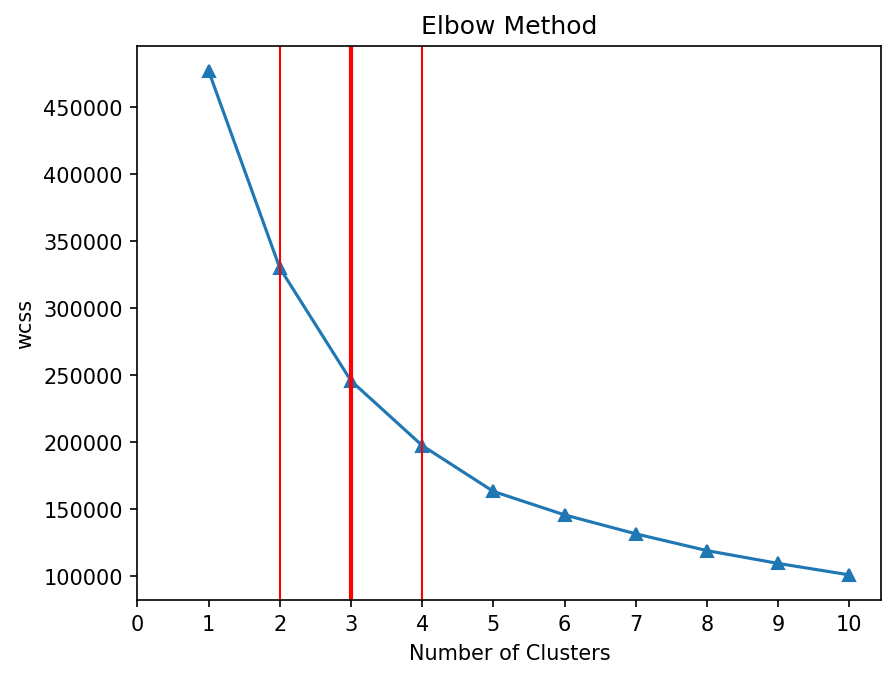

Number of Clusters: 2 , Silhouette score: 0.3434912551790813
Number of Clusters: 3 , Silhouette score: 0.3653225645294843
Number of Clusters: 4 , Silhouette score: 0.3312769660714327
Number of Clusters: 5 , Silhouette score: 0.3351341688591452
Number of Clusters: 6 , Silhouette score: 0.3308323889465946
Number of Clusters: 7 , Silhouette score: 0.2809713283917444
Number of Clusters: 8 , Silhouette score: 0.31048352087064723
Number of Clusters: 9 , Silhouette score: 0.3112216214351629
Number of Clusters: 10 , Silhouette score: 0.3123428819111878
Optimal number of components is: 3


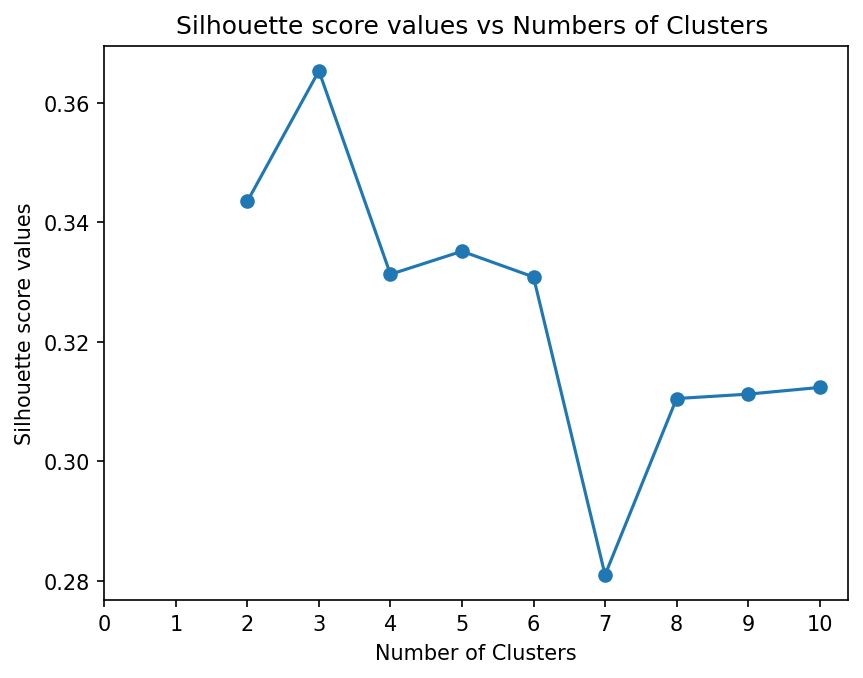

<Figure size 1500x1500 with 0 Axes>

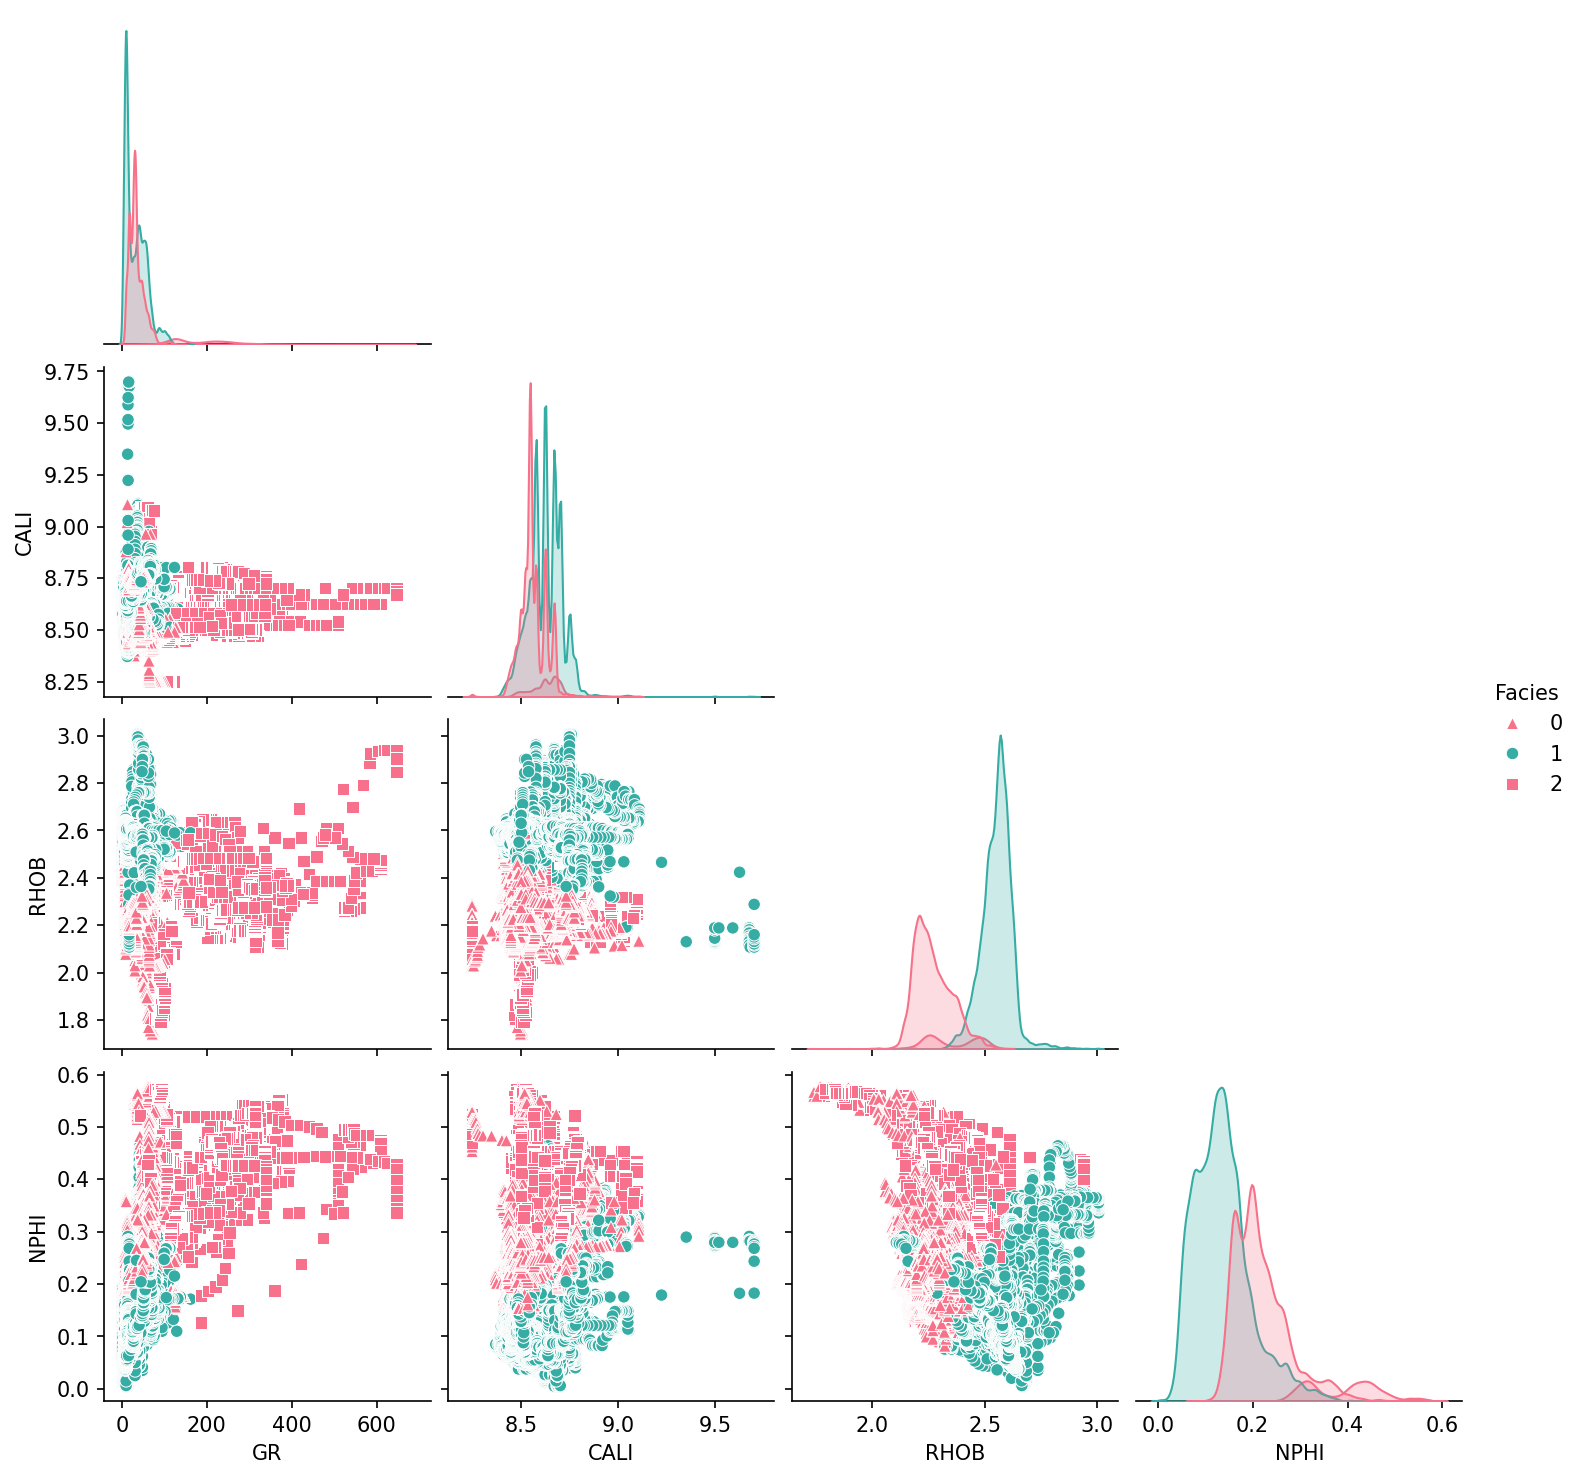

In [16]:
facies_group=['GR', 'CALI', 'RHOB', 'NPHI']#, 'BS', 'ROP', 'RM', 'RD'
dfm=dframe.dropna(subset=facies_group)
dfm[facies_group] = apply_filter(dfm[facies_group], name='All')
data_scaled = DataFrame(Prescale.fit_transform(dfm[facies_group]), 
                        index=dfm[facies_group].index,
                        columns=dfm[facies_group].columns)

df=data_cluster(data_scaled, name='Facies', ncomp=4, nclus=3)
dfm['Facies']=df['Facies']

plt.figure(figsize= (10,10))
ax=sns.pairplot(dfm, vars=facies_group, kind='scatter', diag_kind='kde', hue='Facies', 
                markers=['^','o','s'], palette='husl', height=2.5, corner=True)#, markers=['^','o','s','+','D']

## 预测部分

### VSHALE 预测



**1. 创建 VSHALE 预测数据集:**

* `VSHALE = dfm.drop([...], axis=1)`:
    * 从 `dfm` 数据帧中删除不需要的列，只保留用于预测 VSHALE 的列。
    * 被删除的列包括 'CALI', 'BS', 'ROP', 'RM', 'RD', 'PEF', ... 等。
* `print(VSHALE.info())`: 打印 `VSHALE` 数据帧的信息摘要，包括数据类型、非空值个数等。
* `VShale.dropna(inplace=True)`: 原地删除 `VSHALE` 数据帧中包含缺失值的样本。
* `VShale.shape`: 查看 `VSHALE` 数据帧的形状 (行数和列数)。

**2. 异常值处理:**

* `VShale_df = outlier_removal(VShale, ind=-2)`:
    * 调用名为 `outlier_removal` 的函数 (代码中未提供) 进行异常值处理。
    * 参数：
        * `VShale`: 需要处理的 DataFrame 对象。
        * `ind`: 似乎与处理方法有关，具体含义取决于函数本身的定义 (可能是索引或保留数据的列索引)。
    * 函数返回值被赋值给 `VShale_df` 变量，可能包含去除异常值后的数据。

**注意:**

* 代码中的一些函数和变量没有提供具体定义，需要结合上下文理解其含义和作用。
* 没有提供 `outlier_removal` 函数的具体实现，无法确定其处理异常值的方法。
* 建议根据需求选择合适的异常值处理方法，并查看处理后的数据的分布和统计量，确保数据质量。

<class 'pandas.core.frame.DataFrame'>
Index: 119180 entries, 36157 to 359567
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  119180 non-null  object 
 1   DEPTH      119180 non-null  float64
 2   GR         119180 non-null  float64
 3   RHOB       119180 non-null  float64
 4   NPHI       119180 non-null  float64
 5   VSH        69705 non-null   float64
 6   Facies     119180 non-null  int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 6.8+ MB
None
Before anomaly treatment
                  GR          RHOB          NPHI           VSH        Facies
count  69705.000000  69705.000000  69705.000000  69705.000000  69705.000000
mean      43.359129      2.408598      0.186832      0.304147      0.553906
std       37.800603      0.157124      0.069605      0.222815      0.553150
min        5.494200      2.057700      0.005000      0.000000      0.000000
25%       20.886200      2.260900      0.146700  

Method =  2 :  Isolation Forest

Number of anomalies detected for GR = 4174 out of 69705

Number of anomalies detected for RHOB = 4179 out of 69705

Number of anomalies detected for NPHI = 4163 out of 69705

Number of dataset after anomalies removal = 59376
After anomaly treatment
                  GR          RHOB          NPHI           VSH        Facies
count  59376.000000  59376.000000  59376.000000  59376.000000  59376.000000
mean      37.524812      2.397124      0.176980      0.277086      0.491865
std       19.997023      0.141060      0.048808      0.180436      0.500073
min        7.471800      2.166300      0.065254      0.000000      0.000000
25%       20.478300      2.260300      0.146000      0.127900      0.000000
50%       34.666500      2.404450      0.173300      0.241200      0.000000
75%       50.492025      2.530500      0.207000      0.379625      1.000000
max      103.943900      2.643100      0.333691      1.000000      2.000000


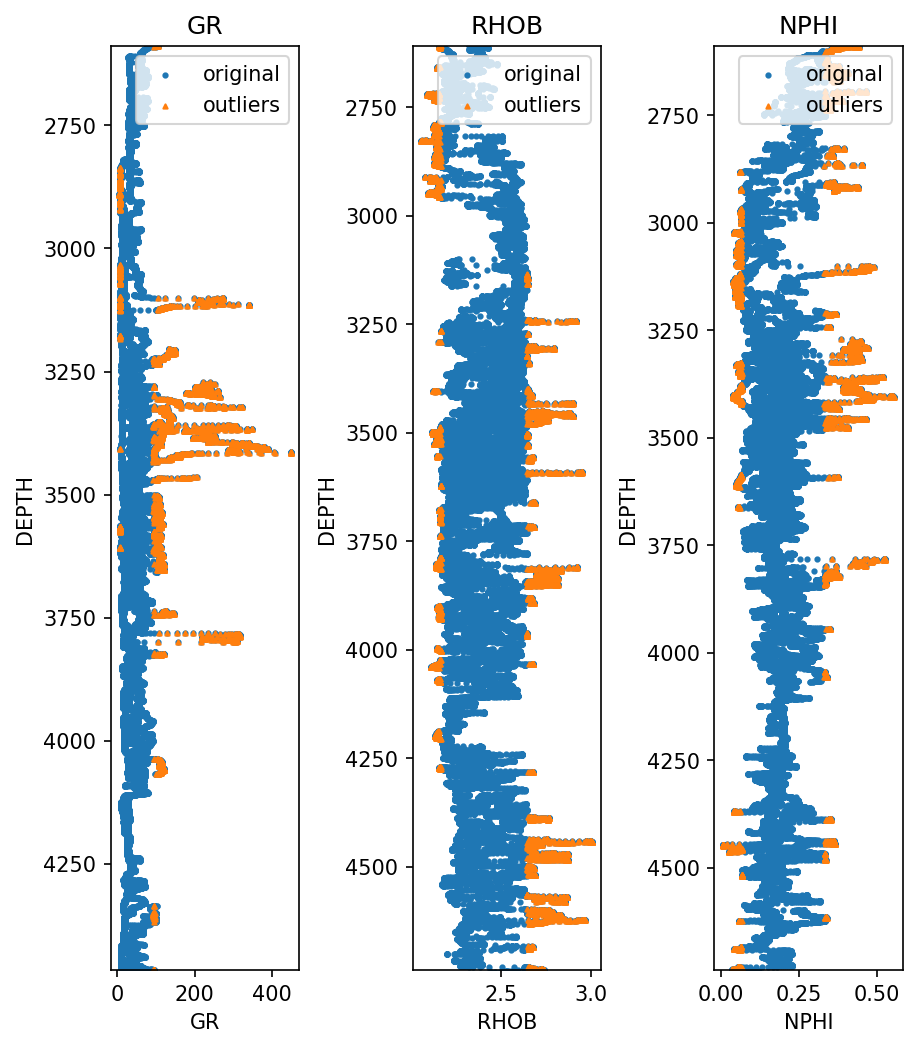

In [17]:
#%% Create DataFrame for each target value - Machine learning
#%% `Create`创建`DataFrame`数据框`for each target value`目标值`- Machine learning`
VShale = dfm.drop(['CALI', 'BS', 'ROP', 'RM', 'RD', 'PEF', 'DT', 'DTS', 'VCARB', 'PHIF', 'SW',#
                      'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1)
print(VShale.info())
# drop all nan values from VShale data
# 从`VShale`数据中`drop`删除所有`nan`值
VShale.dropna(inplace=True)
VShale.shape

VShale_df=outlier_removal(VShale, ind=-2)

#### 可视化

相关性和热力图

**1. 准备数据:**

* `data_scaled = DataFrame(Prescale.fit_transform(VShale_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), ...)`:
    * 从 `VShale_df` 数据帧中去除 'WELL_NAME' 和 'DEPTH' 列，只保留用于计算相关性的特征。
    * 使用 `Prescale` 管道对选定的特征进行标准化 (fit_transform)。
    * 将标准化后的数据转换为 DataFrame 对象 `data_scaled`。

**2. 计算相关系数矩阵:**

* `data_scaled.corr(method='pearson')`: 计算 `data_scaled` 数据帧中各个特征之间的 Pearson 相关系数矩阵。

**3. 绘制相关热图:**

* `plt.figure(figsize= (10,10))`: 创建一个大小为 10 x 10 的 Matplotlib 图形。
* `ax = sns.heatmap(...)`: 使用 Seaborn 库的 `heatmap` 函数创建相关热图。
    * 参数：
        * `data_scaled.corr(method='pearson')`: 计算好的相关系数矩阵。
        * `annot=True`: 在热图中显示相关系数数值。
        * `fmt ='.0%'`: 格式化显示的数值 (保留两位小数并添加百分号)。
        * `cmap="Spectral_r"`: 使用 "Spectral_r" 颜色映射。
        * `square=True`: 使得热图呈正方形。
* `plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")`: 设置 x 轴刻度标签的旋转角度 (45 度) 和对齐方式 (右对齐)。
* `plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")`: 设置 y 轴刻度标签的旋转角度 (0 度) 和对齐方式 (右对齐)。
* `ax.set_title('VShale correlation',weight='bold', fontsize=24)`: 设置热图的标题 (VShale 相关性)、字体样式 (粗体) 和大小 (24)。

**总结:**

这段代码计算了 VSHALE 预测模型中各个特征之间的相关系数，并使用 Seaborn 库绘制了相关热图。该热图可以帮助您直观地观察特征之间的相关性强弱，并判断是否存在冗余特征。


Text(0.5, 1.0, 'VShale correlation')

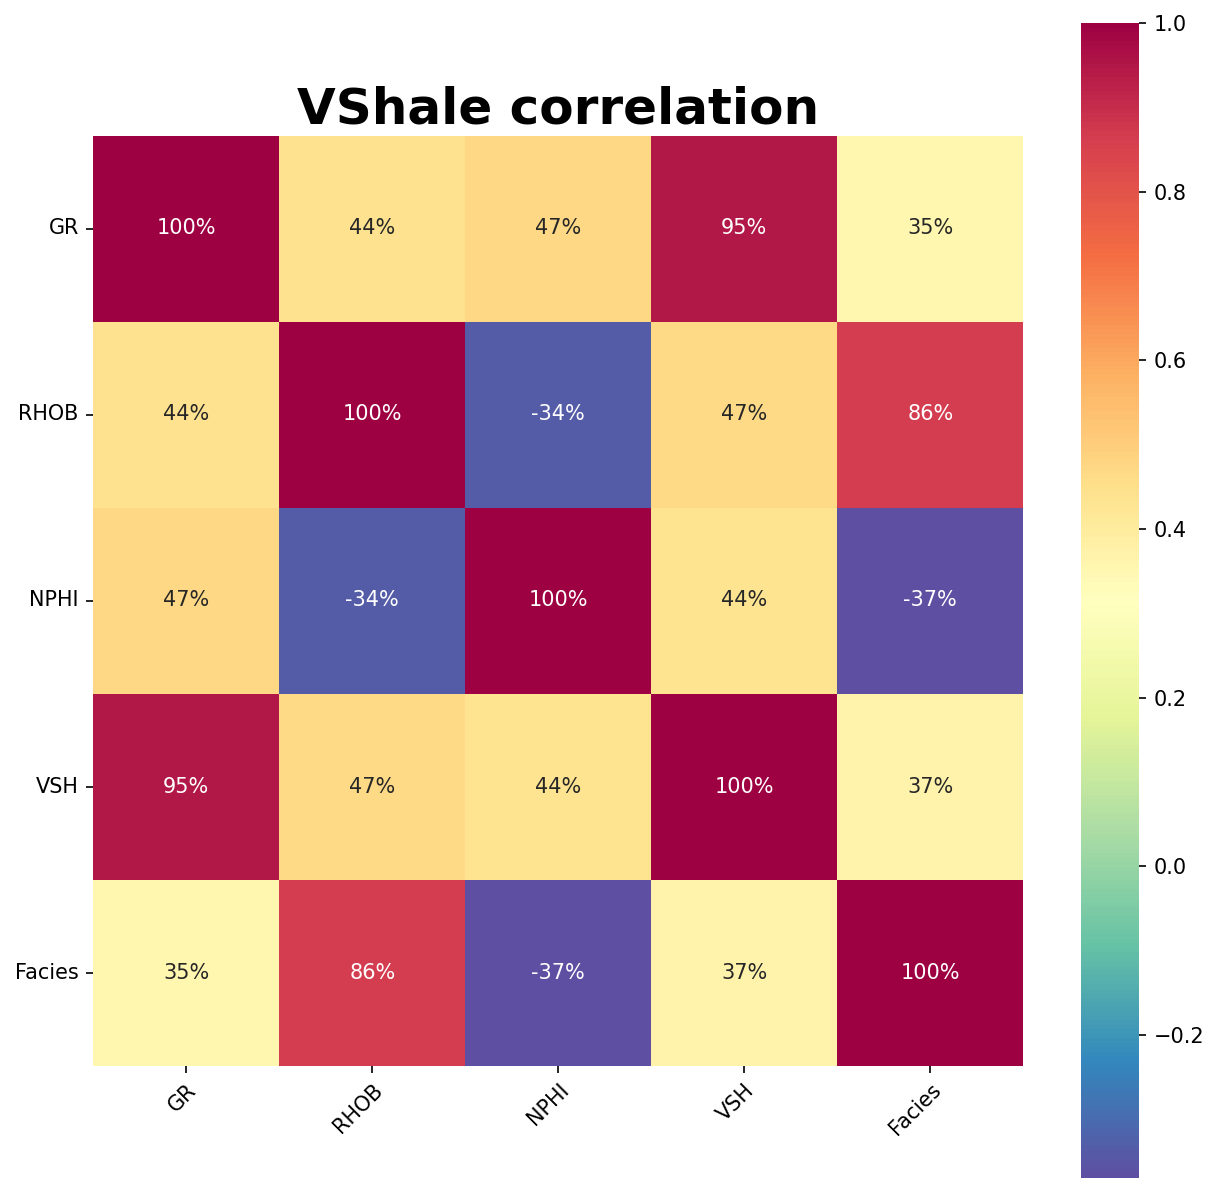

In [18]:
# Visualize correlation
# `Visualize`可视化`correlation`相关性
data_scaled = DataFrame(Prescale.fit_transform(VShale_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=VShale_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=VShale_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
# 绘制`heatmap`热图
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('VShale correlation',weight='bold', fontsize=24)



**1. 统计分析:**

* `well_stat = VShale_df.groupby(['WELL_NAME']).describe()`:
    * 基于 `WELL_NAME` 列对 `VShale_df` 数据帧进行分组。
    * 对每个分组 (井) 的特征值进行描述性统计，得到 `well_stat` 数据帧。
* `print(well_stat)`: 打印每个井的特征值的描述性统计信息，例如均值、标准差、最小值、最大值等。

**2. 划分测试集和训练集:**

* `VShale_blind = VShale_df[VShale_df['WELL_NAME'] == 'Well_F11A']`:
    * 筛选出 `WELL_NAME` 为 'Well_F11A' 的样本，将其作为测试集 (VShale_blind)。
* `VShale = VShale_df[VShale_df['WELL_NAME'] != 'Well_F11A']`:
    * 筛选出 **不是** 'Well_F11A' 的样本，将其作为训练集 (VShale)。

**3. 可视化聚类结果:**

* `log_plot (VShale_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')`:
    * 调用 `log_plot` 函数 (之前已解释) 绘制测试集 (VShale_blind) 的测井曲线和地层 (Facies) 的组合图。
    * 参数：
        * `VShale_blind`: 测试集数据。
        * `name`: 地层列名 ('Facies')。
        * `ycbar`: 控制颜色条中每个标签的垂直位置偏移 (10)。
        * `title`: 图形标题 ('Log display with Facies for Test')。
* `log_plot (VShale[VShale['WELL_NAME'] == 'Well_F1C'], name='Facies', ycbar=10, ...)`:
    * 同样使用 `log_plot` 函数绘制训练集中一个特定的井 (Well_F1C) 的测井曲线和地层 (Facies) 的组合图。
    * 其他参数与测试集的绘制相同。

**总结:**

这段代码首先对每个井的特征值进行统计分析，然后将数据分为测试集和训练集。最后，分别绘制测试集和训练集中特定井的测井曲线和地层 (Facies) 的组合图，可以直观地观察地层分布和数据特性。

              DEPTH                                                            \
              count         mean         std        min        25%        50%   
WELL_NAME                                                                       
Well_F1      2328.0  3443.656186   75.021654  3320.0000  3380.6750  3438.8500   
Well_F11A    1503.0  3659.715037   45.219361  3575.3000  3621.1500  3658.7000   
Well_F11B   12104.0  4053.554486  403.889519  3351.6000  3694.2750  4061.2500   
Well_F11T2   1791.0  4437.825907   59.368993  4334.7000  4383.2500  4435.9000   
Well_F15     4540.0  3121.923063  309.217209  2601.0108  2821.4955  3180.5118   
Well_F15A    8801.0  3377.877185  416.352852  2608.6308  3040.9896  3389.2236   
Well_F15B    1298.0  3380.640592   60.742467  3277.3620  3326.7777  3383.3562   
Well_F15C    1779.0  3065.994851   89.202267  2915.8692  2990.3166  3058.0584   
Well_F15D   10796.0  4049.915904  332.239404  3467.4000  3752.7750  4062.0500   
Well_F1A     1948.0  3535.36

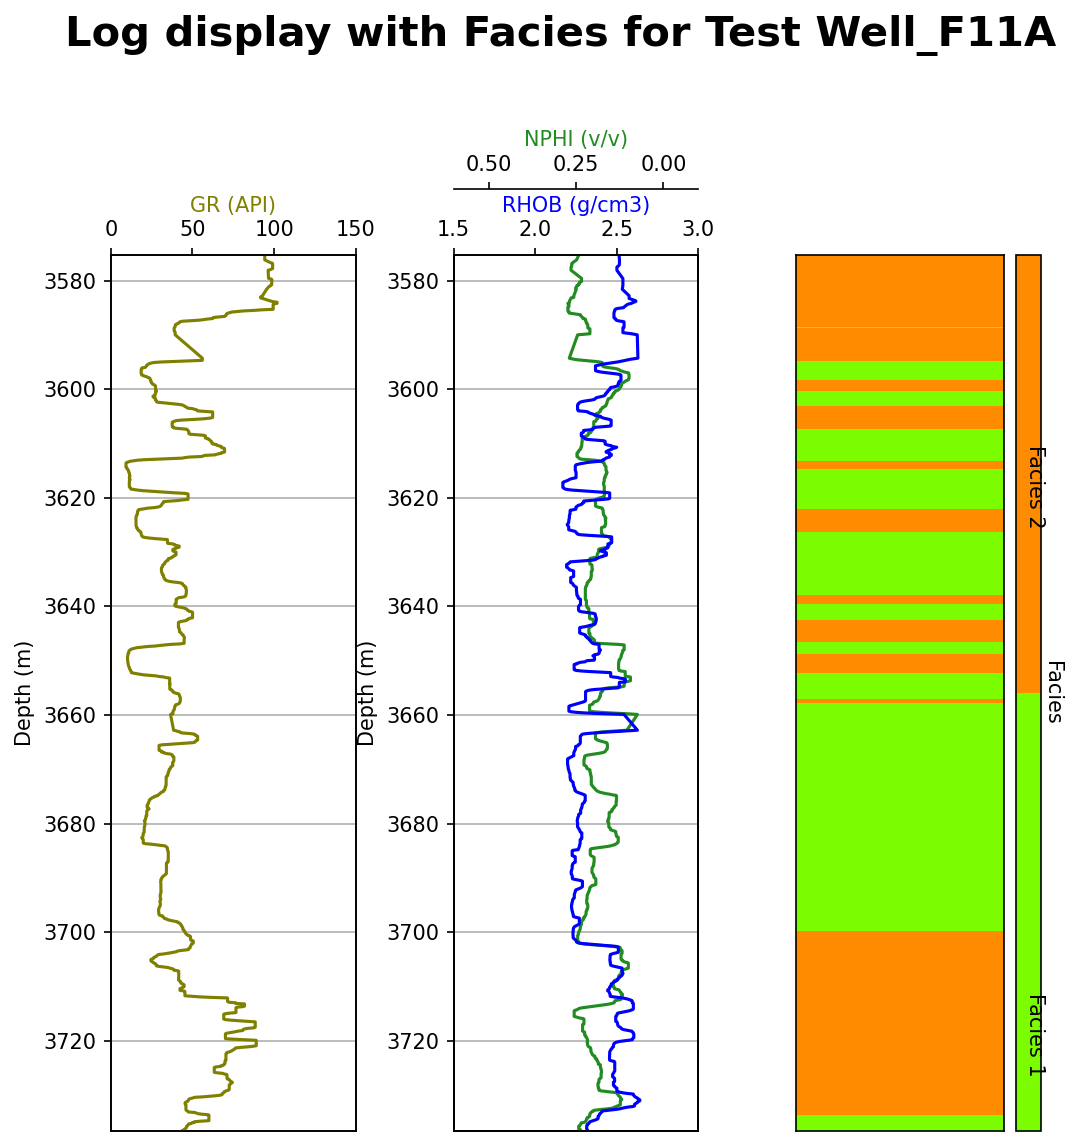

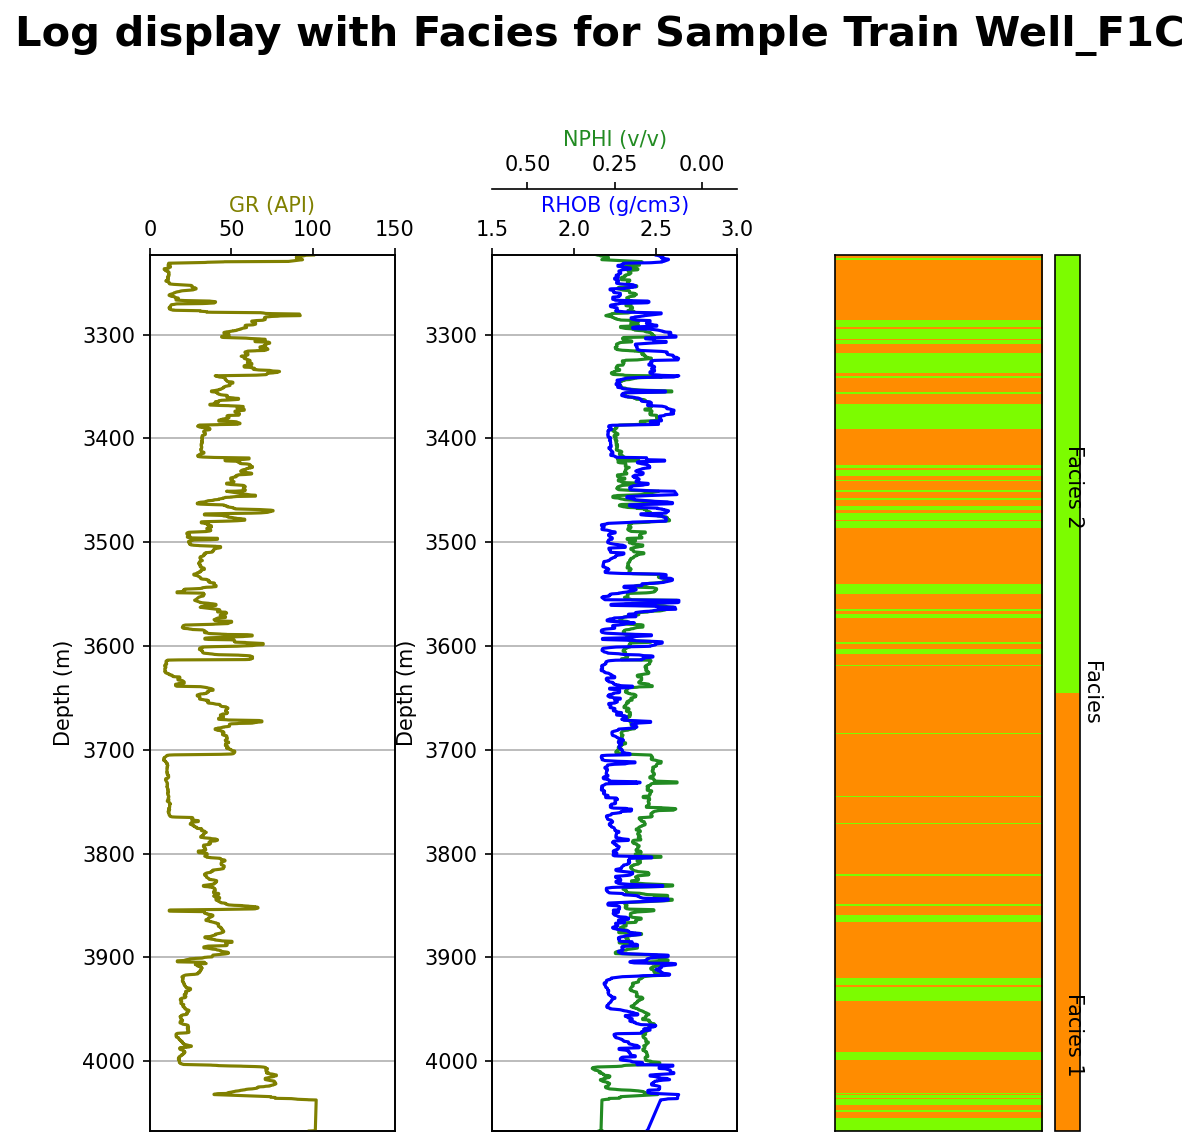

In [19]:
# check out statistics by well 
# 按`well`井`check out`检查`statistics`统计
well_stat=VShale_df.groupby(['WELL_NAME']).describe()
print(well_stat)
# create blind test data with Well_F11A
# 创建`blind test`盲测试数据`with Well_F11A`
VShale_blind = VShale_df[VShale_df['WELL_NAME'] == 'Well_F11A']
VShale = VShale_df[VShale_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
# 可视化`zone clusters`区域聚类`clusters`
log_plot (VShale_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (VShale[VShale['WELL_NAME'] == 'Well_F1C'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

#### 测试

**1. 循环遍历地层进行预测:**

* `Y_pred_VShale=np.zeros(VShale_blind.shape[0])`: 创建一个空数组 `Y_pred_VShale` 用于存储最终的预测值，其长度等于测试集的样本数量。
* 循环遍历 `VShale` 数据帧中 `Facies` 列的唯一值 (地层类型)：
    * 筛选出属于当前地层的样本，并复制一份数据 (`VShale_split`)。
    * 从 `VShale_split` 中提取目标变量 (VSH) 和属性 (其他特征)，并进行必要的处理：
        * `target` 提取 'DEPTH' 和 'VSH' 列，并设置索引为 'DEPTH'。
        * `attributes` 剔除 'WELL_NAME', 'DEPTH', 'VSH', 'Facies' 列，并应用 `apply_filter` 函数 (未提供定义) 进行预处理。
    * 调用 `model_predict` 函数 (之前已解释) 训练模型并进行预测：
        * 参数：
            * `attributes`: 经过预处理的属性数据。
            * `target`: 目标变量 (VSH)。
            * `'Facies %s' % str(i+1)`: 用于区分不同地层的模型名称。
            * `name`: 地层名称 (VSHale)。
        * 函数返回训练好的模型 (`model`)、预处理管道 (`Prescale`) 和网格搜索结果 (`results`)。
        * 打印模型的最佳超参数 (`model.best_params_`)。
    * **测试集预测:**
        * 筛选出测试集中属于当前地层的样本 (`VShale_blind_split`)。
        * 提取测试集中的目标变量 (VSH) 和属性，并进行处理：
            * `Y_blind` 提取 'DEPTH' 和 'VSH' 列，并设置索引为 'DEPTH'。
            * `X_blind` 剔除 'WELL_NAME', 'DEPTH', 'VSH', 'Facies' 列，并应用 `apply_filter` 函数 (未提供定义) 进行预处理。
        * 使用训练好的模型 (`model`) 和预处理管道 (`Prescale`) 对测试集进行预测，并将结果保存到 `Y_blind_pred` 数组中。
    * 将 `Y_blind_pred` 预测值根据地层类别对应地保存到 `Y_pred_VShale` 数组中。

**2. 获取真实值:**

* `Y_test_VShale=VShale_blind.VSH.values`: 从测试集中提取真实的 VSH 值并转换为数组 `Y_test_VShale`。

**总结:**

这段代码循环遍历每个地层，使用训练集中的数据训练模型，并用该模型来预测测试集中对应地层的 VSH 值。最后，将所有地层的预测值合并到 `Y_pred_VShale` 数组中，并获取测试集的真实 VSH 值 `Y_test_VShale`。

Before applying noise-filter [VShale]
                  GR          RHOB          NPHI
count  29377.000000  29377.000000  29377.000000
mean      30.490192      2.277703      0.194815
std       15.083481      0.078055      0.037121
min        7.471800      2.166300      0.081700
25%       18.106000      2.212500      0.165000
50%       28.414400      2.262000      0.192000
75%       39.306700      2.329800      0.216400
max      102.460602      2.565000      0.333691
After applying noise-filter [VShale]
                  GR          RHOB          NPHI
count  29377.000000  29377.000000  29377.000000
mean      30.561140      2.278106      0.195600
std       14.983650      0.076777      0.036713
min        7.532800      2.167100      0.113300
25%       18.144000      2.213800      0.166000
50%       28.629000      2.263600      0.193000
75%       39.447000      2.329200      0.217300
max      100.427002      2.557000      0.333467


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])
Best: 0.855809 using {'C': 1.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1     0.855809  0.007768      {'C': 1.0, 'gamma': 0.6309573444801936}
2     0.849354  0.008856     {'C': 10.0, 'gamma': 0.6309573444801936}
3     0.846576  0.007783   {'C': 10.0, 'gamma': 0.025118864315095808}
4     0.846012  0.008086  {'C': 100.0, 'gamma': 0.025118864315095808}
5     0.844677  0.007946    {'C': 1.0, 'gamma': 0.025118864315095808}
6     0.837652  0.008174    {'C': 100.0, 'gamma': 0.6309573444801936}
7     0.826978  0.008585                 {'C': 100.0, 'gamma': 0.001}
8     0.823379  0.007548                

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'C': 100.0, 'gamma': 0.6309573444801936}
Before applying noise-filter [VShale]
                GR        RHOB        NPHI
count  705.000000  705.000000  705.000000
mean    53.160004    2.487104    0.178315
std     24.006940    0.064874    0.051584
min     10.142000    2.336000    0.074000
25%     36.070000    2.456000    0.125000
50%     47.178000    2.484000    0.184000
75%     70.924000    2.526000    0.222000
max    101.852000    2.642000    0.273000
After applying noise-filter [VShale]
                GR        RHOB        NPHI
count  705.000000  705.000000  705.000000
mean    53.543716    2.490199    0.178594
std     23.785555    0.059919    0.050838
min     10.402000    2.364000    0.099000
25%     38.057000    2.457000    0.124000
50%     45.963000    2.487000    0.184000
75%     71.136000    2.526000    0.220000
max     99.438000    2.626000    0.273000
Before applying noise-filter [VShale]
             GR   RHOB   NPHI
count    4.000  4.000  4.000
mean   103.582  2.513  0.302

ValueError: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=3.

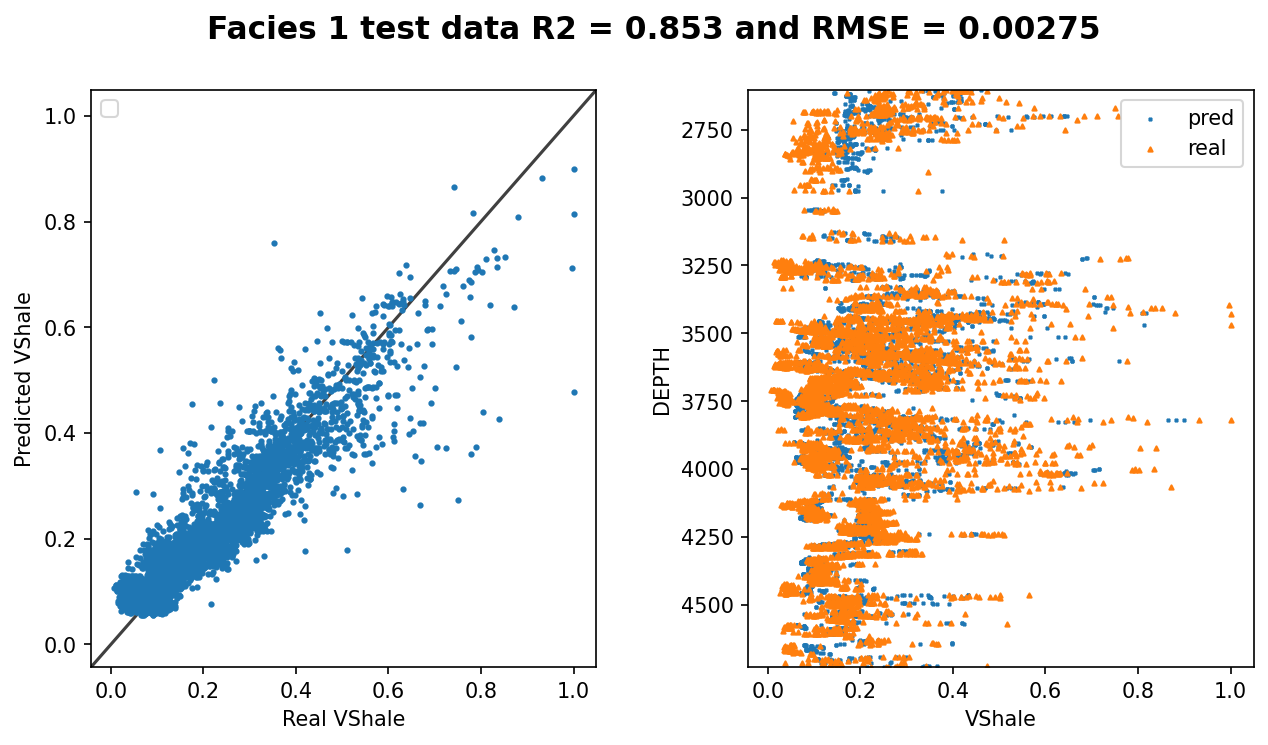

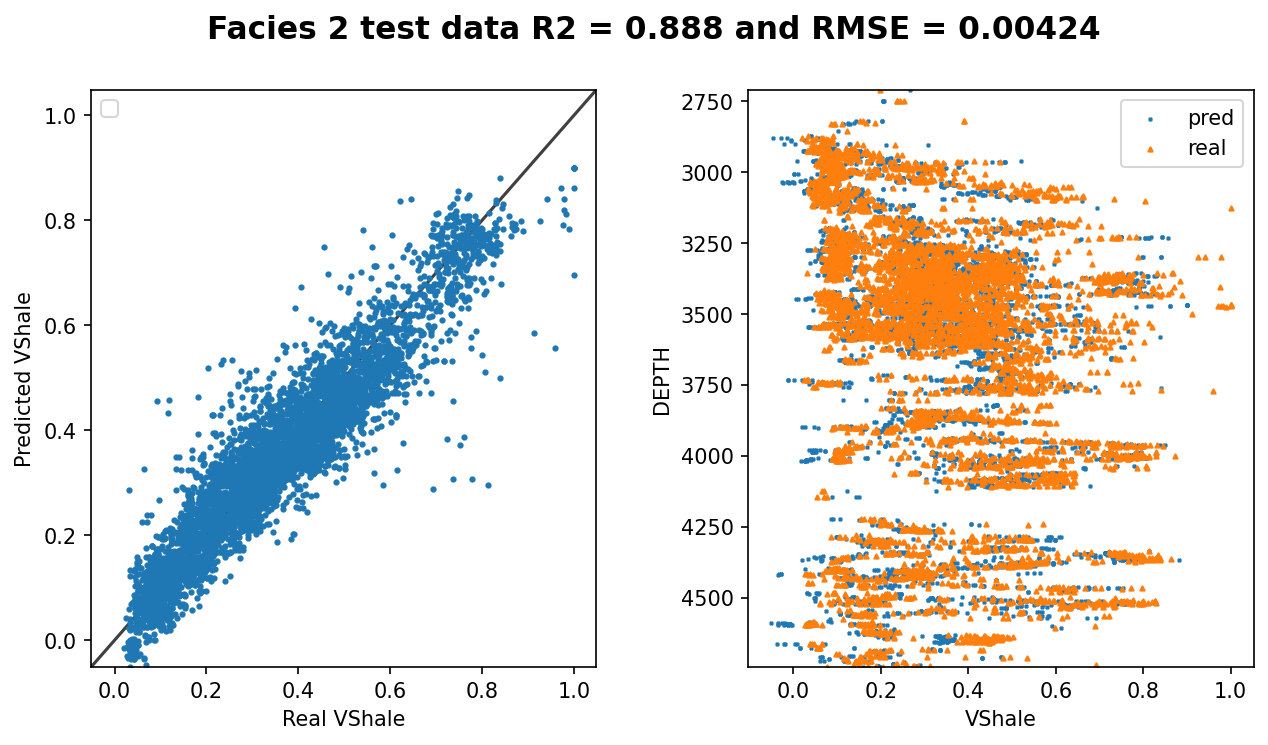

In [20]:
# Split dataset into target and attributes
# `Split`划分数据集为`target`目标和`attributes`属性
Y_pred_VShale=np.zeros(VShale_blind.shape[0])# array for saving predictions # 用于保存预测的数组
name='VShale'
for i in VShale['Facies'].unique():
    VShale_split=VShale[VShale.Facies.values==i].copy()
    target = VShale_split[['DEPTH', 'VSH']]
    target.set_index('DEPTH', inplace=True)
    attributes = VShale_split.drop(['WELL_NAME', 'DEPTH', 'VSH', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    # 测试`blind well`盲井
    VShale_blind_split=VShale_blind[VShale_blind.Facies.values==i].copy()
    Y_blind = VShale_blind_split[['DEPTH', 'VSH']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = VShale_blind_split.drop(['WELL_NAME', 'DEPTH', 'VSH', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    # 保存预测
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_VShale[VShale_blind.Facies.values==i]=Y_blind_pred
    
Y_test_VShale=VShale_blind.VSH.values

#### 模型评估


**1. 评估模型性能:**

* `mse = mean_squared_error(Y_test_VShale, Y_pred_VShale)`: 计算测试集真实 VSH 值 (`Y_test_VShale`) 和预测值 (`Y_pred_VShale`) 之间的均方误差 (MSE)。
* `r2 = r2_score(Y_test_VShale, Y_pred_VShale)`: 计算测试集真实 VSH 值 (`Y_test_VShale`) 和预测值 (`Y_pred_VShale`) 之间的 R 方值 (R2)。

**2. 可视化预测结果:**

* `plt.plot(Y_test_VShale, VShale_blind.DEPTH, c='cyan')`: 
    * 使用蓝色 ('cyan') 线段图绘制测试集的真实 VSH 值 (`Y_test_VShale`) 随深度 (VShale_blind.DEPTH) 的变化趋势。
* `plt.plot(Y_pred_VShale, VShale_blind.DEPTH, c='darkslategrey', linestyle='-.')`:
    * 使用深灰色 ('darkslategrey') 虚线图 ('-.') 绘制测试集的预测 VSH 值 (`Y_pred_VShale`) 随深度 (VShale_blind.DEPTH) 的变化趋势。
* 设置网格 (plt.grid())、坐标轴标签、坐标轴范围、图例、以及标题。
* 标题中包含 R2 值 (格式化成三位小数) 和 MSE 值 (格式化成五位小数)。

**总结:**

这段代码计算了模型的均方误差 (MSE) 和 R 方值 (R2) 来评估模型的预测性能，并利用 Matplotlib 绘制了测试集真实 VSH 值和预测 VSH 值随深度的变化曲线，直观地展示了模型的预测结果。

In [21]:
#test the accuracy
# 测试准确性
mse = mean_squared_error(Y_test_VShale, Y_pred_VShale)
r2 = r2_score(Y_test_VShale, Y_pred_VShale)

plt.plot(Y_test_VShale, VShale_blind.DEPTH, c='cyan')
plt.plot(Y_pred_VShale, VShale_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.grid()
plt.xlabel('VShale (v/v)')
plt.xlim(0,1) 
plt.ylim(np.min(VShale_blind.DEPTH),np.max(VShale_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)

NameError: name 'Y_test_VShale' is not defined

### DT Prediction

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119180 entries, 36157 to 359425
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  119180 non-null  object 
 1   DEPTH      119180 non-null  float64
 2   GR         119180 non-null  float64
 3   CALI       119180 non-null  float64
 4   RHOB       119180 non-null  float64
 5   NPHI       119180 non-null  float64
 6   DT         77991 non-null   float64
 7   Facies     119180 non-null  int32  
dtypes: float64(6), int32(1), object(1)
memory usage: 12.7+ MB
None
Before anomaly treatment
                  GR          CALI          RHOB          NPHI            DT  \
count  77991.000000  77991.000000  77991.000000  77991.000000  77991.000000   
mean      40.617470      8.611018      2.474541      0.168194     77.186891   
std       49.550096      0.090364      0.140250      0.093305     14.433990   
min        1.553500      8.371600      2.057700      0.005000     

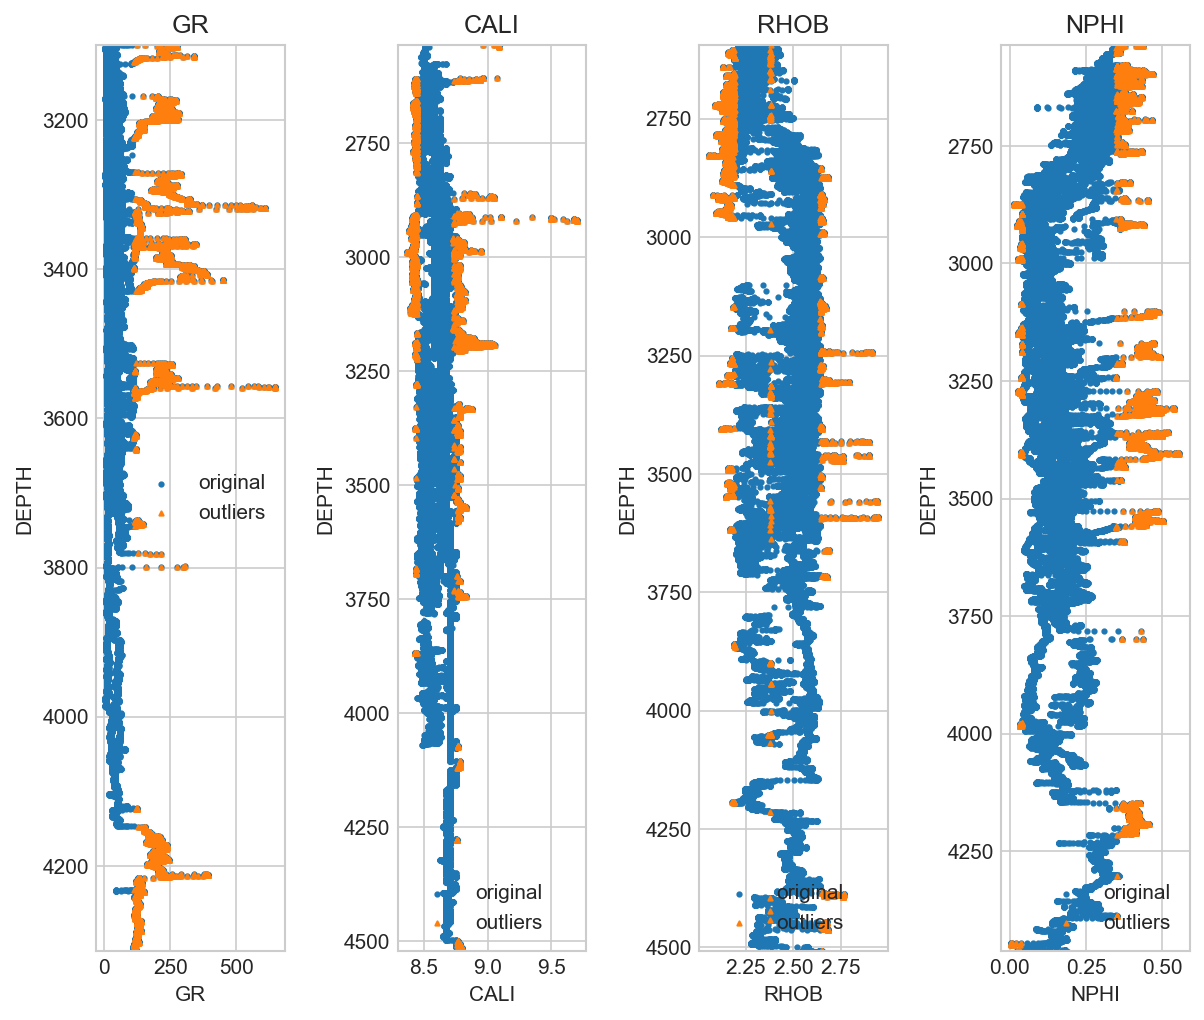

In [393]:
DT = dfm.drop(['BS', 'ROP', 'RM', 'RD', 'DTS', 'VCARB', 'VSH', 'PHIF', 'SW', 'PEF',
                  'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1) 
print(DT.info())
# drop all nan values from VShale data
DT.dropna(inplace=True)
DT.shape

DT_df=outlier_removal(DT, ind=-2)

Text(0.5, 1, 'DT correlation')

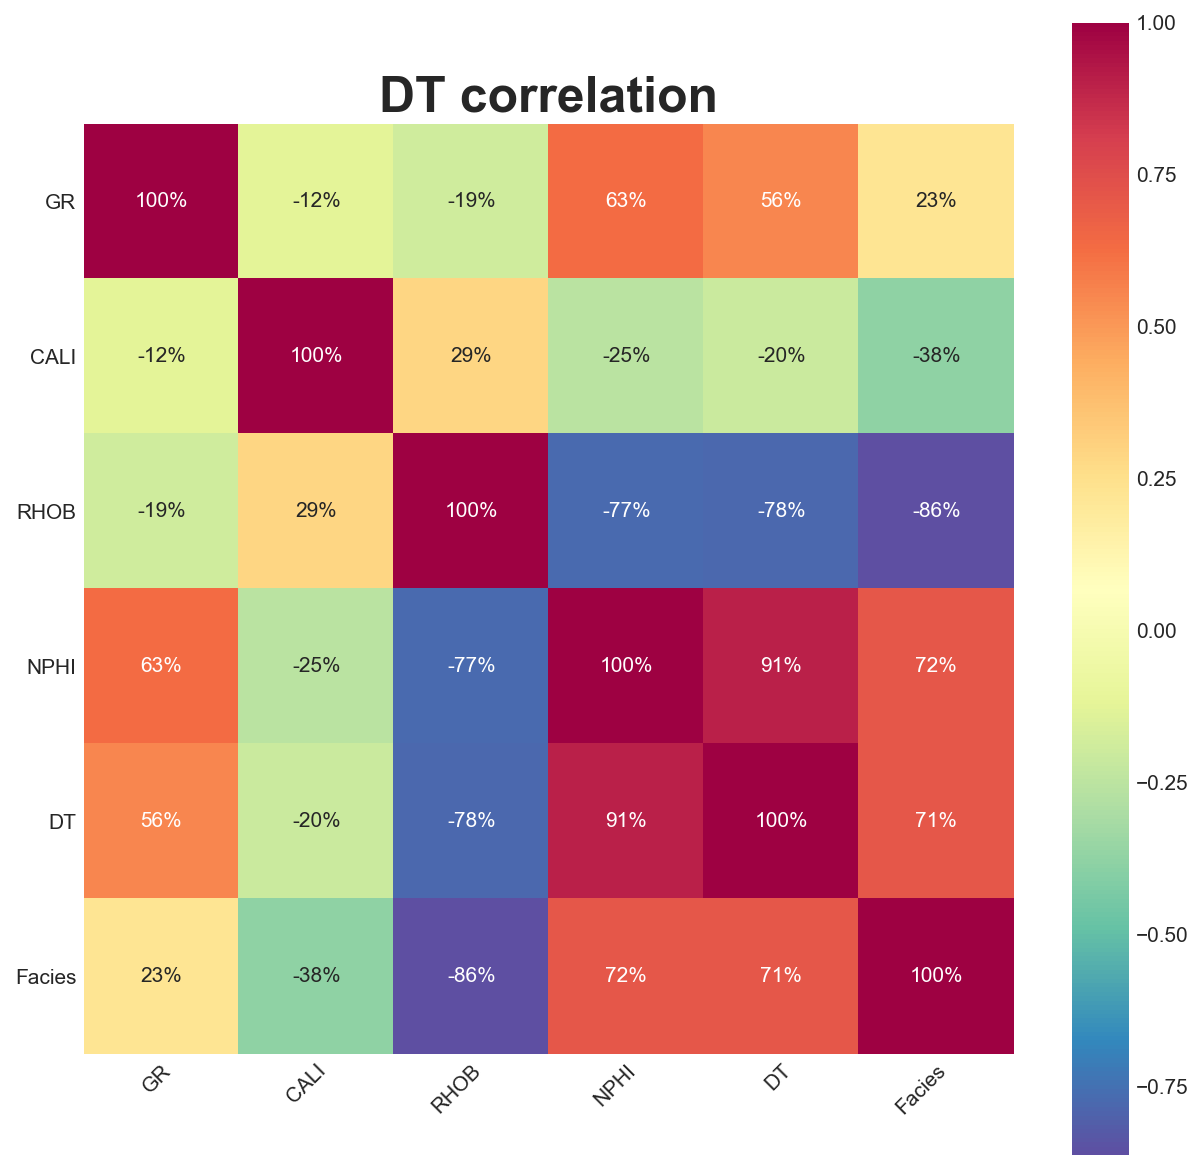

In [394]:
# Visualize correlation
data_scaled = DataFrame(Prescale.fit_transform(DT_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=DT_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=DT_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('DT correlation',weight='bold', fontsize=24)

              DEPTH                                                            \
              count         mean         std        min        25%        50%   
WELL_NAME                                                                       
Well_F1      8958.0  3106.156821  283.623195  2618.1000  2864.7250  3093.4500   
Well_F11A    9911.0  3171.080315  311.289289  2577.0000  2923.0500  3172.1000   
Well_F11T2  14978.0  3527.842576  530.545846  2577.0000  3068.1250  3528.0500   
Well_F15     5558.0  3151.019000  309.781504  2539.2888  2925.8133  3193.6182   
Well_F15A    7009.0  3473.143533  375.405162  2616.2508  3231.6420  3501.2376   
Well_F15B    1751.0  3326.546119   83.008278  3174.9492  3256.1022  3322.7772   
Well_F15C     977.0  3023.890382   78.568122  2910.0780  2958.9984  3004.1088   
Well_F1A     8991.0  3117.511111  291.520785  2619.8000  2869.9500  3105.5000   
Well_F1B     2549.0  3275.266301  100.520921  3098.5000  3162.2000  3291.7000   
Well_F5      2600.0  3532.75

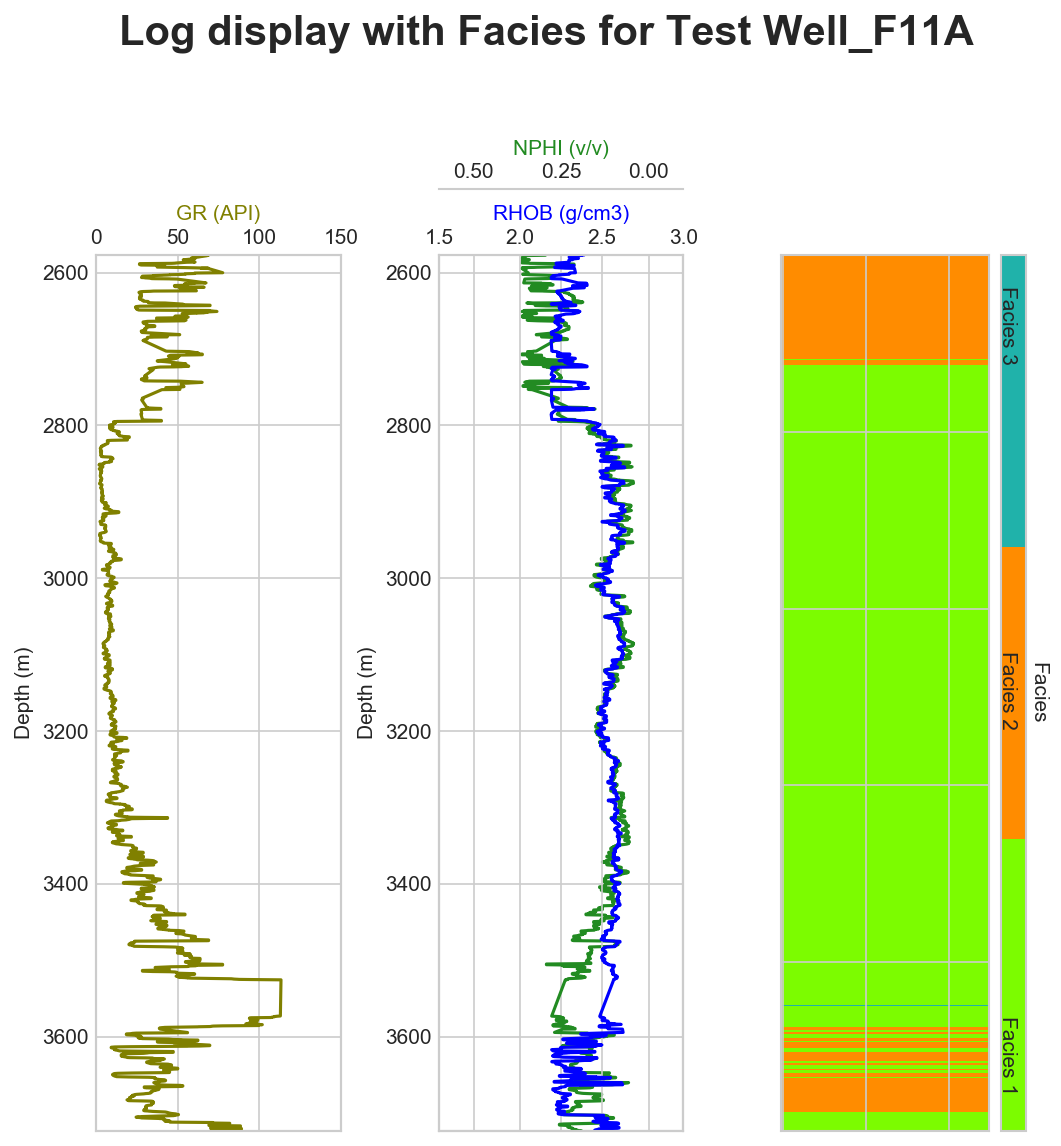

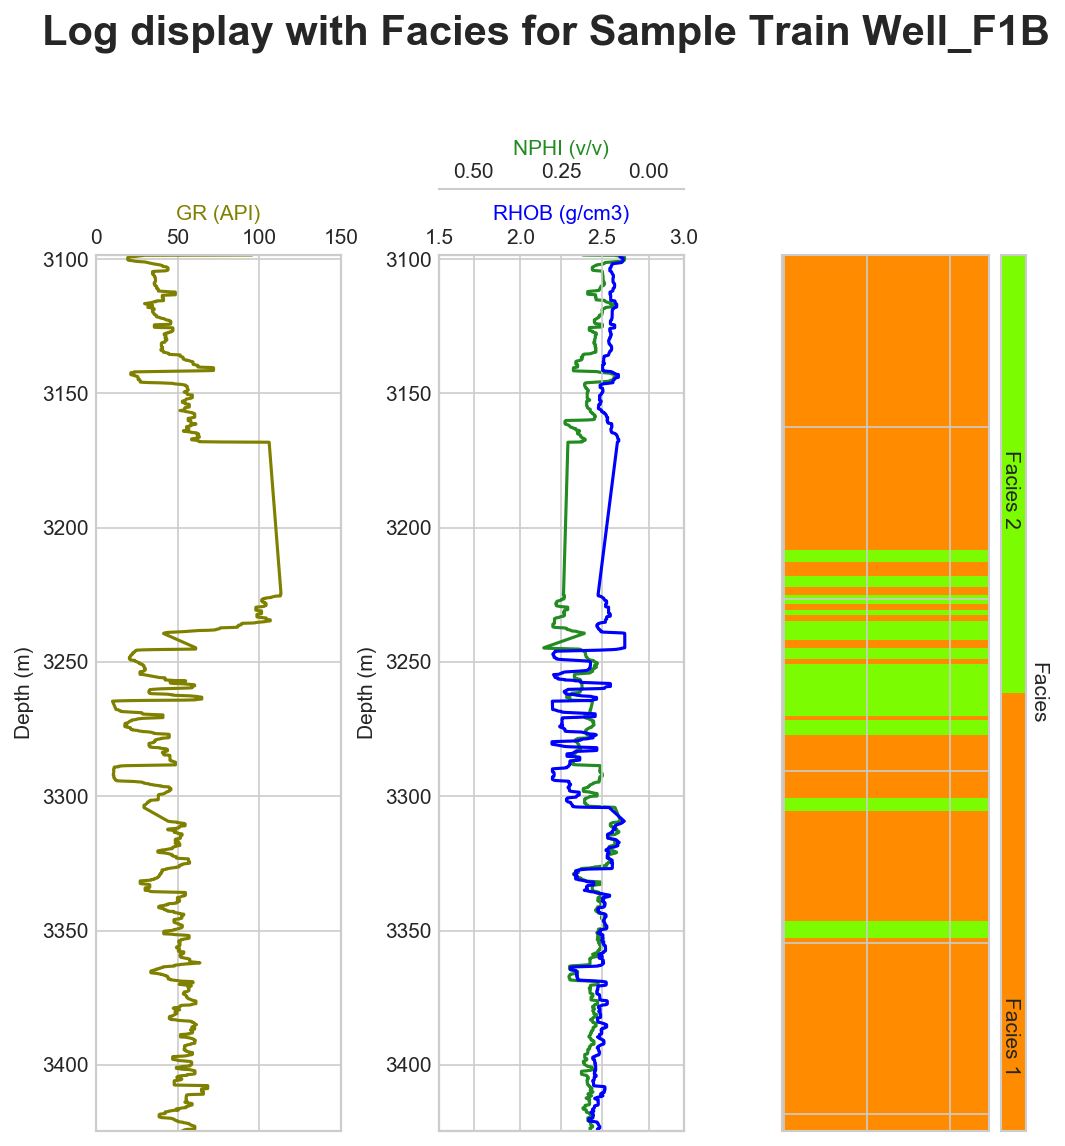

In [395]:
# check out statistics by well 
well_stat=DT_df.groupby(['WELL_NAME']).describe()
print(well_stat)

# create blind test data with Well_F11A
DT_blind = DT_df[DT_df['WELL_NAME'] == 'Well_F11A']
DT = DT_df[DT_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
log_plot (DT_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (DT[DT['WELL_NAME'] == 'Well_F1B'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

Before applying noise-filter [DT]
                  GR          CALI          RHOB          NPHI
count  11308.000000  11308.000000  11308.000000  11308.000000
mean      39.523555      8.544836      2.298356      0.235732
std       17.635450      0.061717      0.080132      0.046238
min        2.385800      8.448600      2.188600      0.090000
25%       29.039500      8.500000      2.232000      0.203000
50%       34.886800      8.546900      2.280000      0.231600
75%       49.286999      8.578000      2.352600      0.259800
max      113.367203      8.758700      2.541200      0.362000
After applying noise-filter [DT]
                  GR          CALI          RHOB          NPHI
count  11308.000000  11308.000000  11308.000000  11308.000000
mean      39.636135      8.545307      2.298775      0.236671
std       17.328934      0.060716      0.078175      0.044834
min        2.539300      8.450000      2.189000      0.131900
25%       29.367201      8.500000      2.233300      0.206200
5

No handles with labels found to put in legend.


{'C': 100.0, 'gamma': 15.848931924611133}
Before applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  1978.000000  1978.000000  1978.000000  1978.000000
mean     37.509560     8.592063     2.266345     0.243646
std      13.075454     0.038030     0.056066     0.059420
min       9.232000     8.535000     2.189000     0.122000
25%      28.702750     8.547000     2.227000     0.206000
50%      34.006000     8.578000     2.249000     0.233000
75%      47.394500     8.625000     2.299000     0.282750
max      77.612000     8.703000     2.417000     0.362000
After applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  1978.000000  1978.000000  1978.000000  1978.000000
mean     37.589909     8.592424     2.267179     0.244753
std      12.676818     0.037999     0.053997     0.058543
min       9.697000     8.547000     2.190000     0.128000
25%      28.831000     8.547000     2.228000     0.207000
50%      34.006000 

No handles with labels found to put in legend.


{'C': 100.0, 'gamma': 15.848931924611133}
Before applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  7929.000000  7929.000000  7929.000000  7929.000000
mean     19.558387     8.648150     2.554329     0.115879
std      19.917398     0.032305     0.048590     0.045385
min       1.812000     8.578000     2.336000     0.043000
25%       7.518000     8.625000     2.520000     0.084000
50%      10.663000     8.625000     2.563000     0.108000
75%      25.452000     8.672000     2.592000     0.136000
max     113.306000     8.750000     2.642000     0.292000
After applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  7929.000000  7929.000000  7929.000000  7929.000000
mean     19.681214     8.648412     2.555075     0.116366
std      19.967748     0.032090     0.047524     0.045223
min       1.975000     8.578000     2.364000     0.044000
25%       7.551000     8.625000     2.521000     0.085000
50%      10.696000 

No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: 0.776528 using {'C': 100.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1     0.776528  0.162628    {'C': 100.0, 'gamma': 0.6309573444801936}
2     0.742847  0.145583     {'C': 10.0, 'gamma': 0.6309573444801936}
3     0.712700  0.2

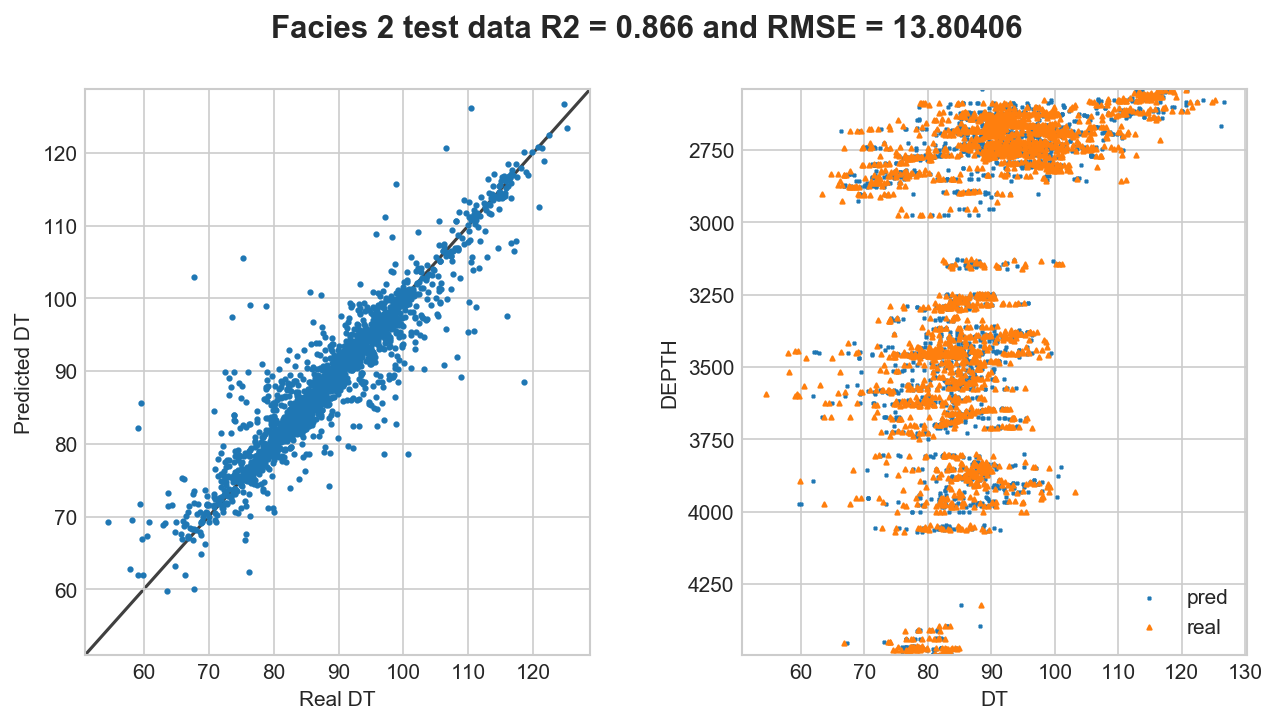

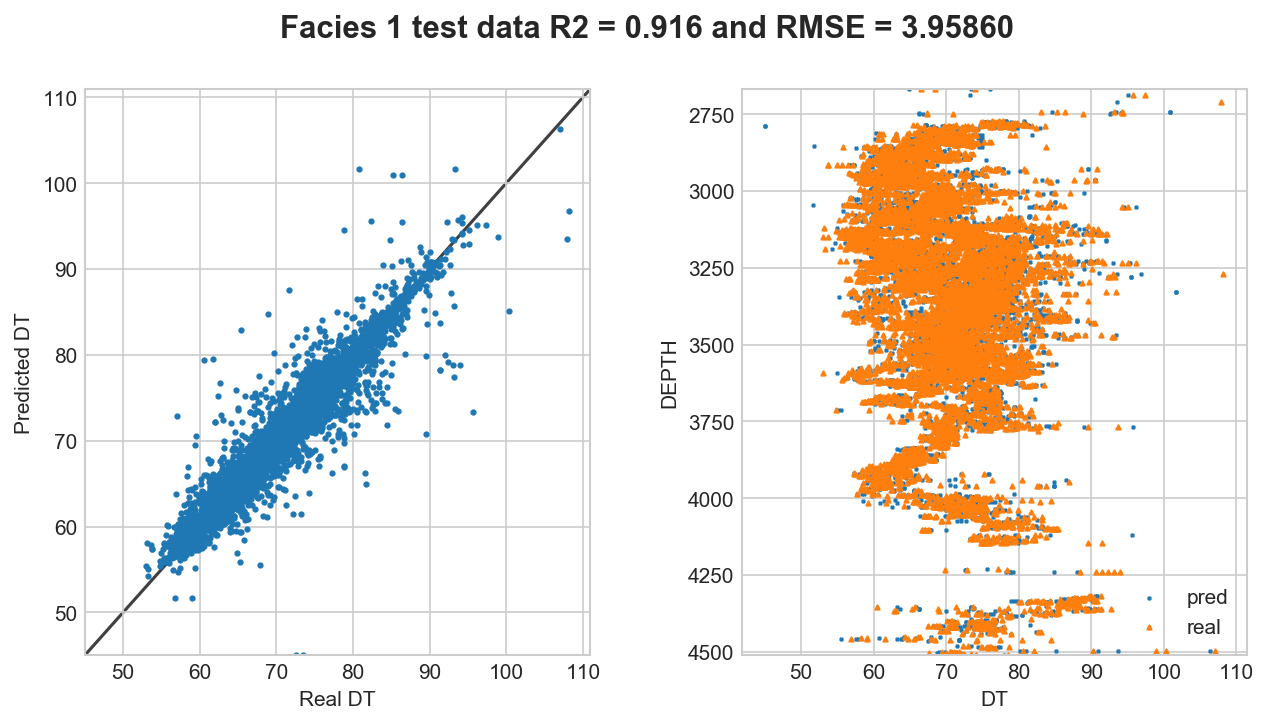

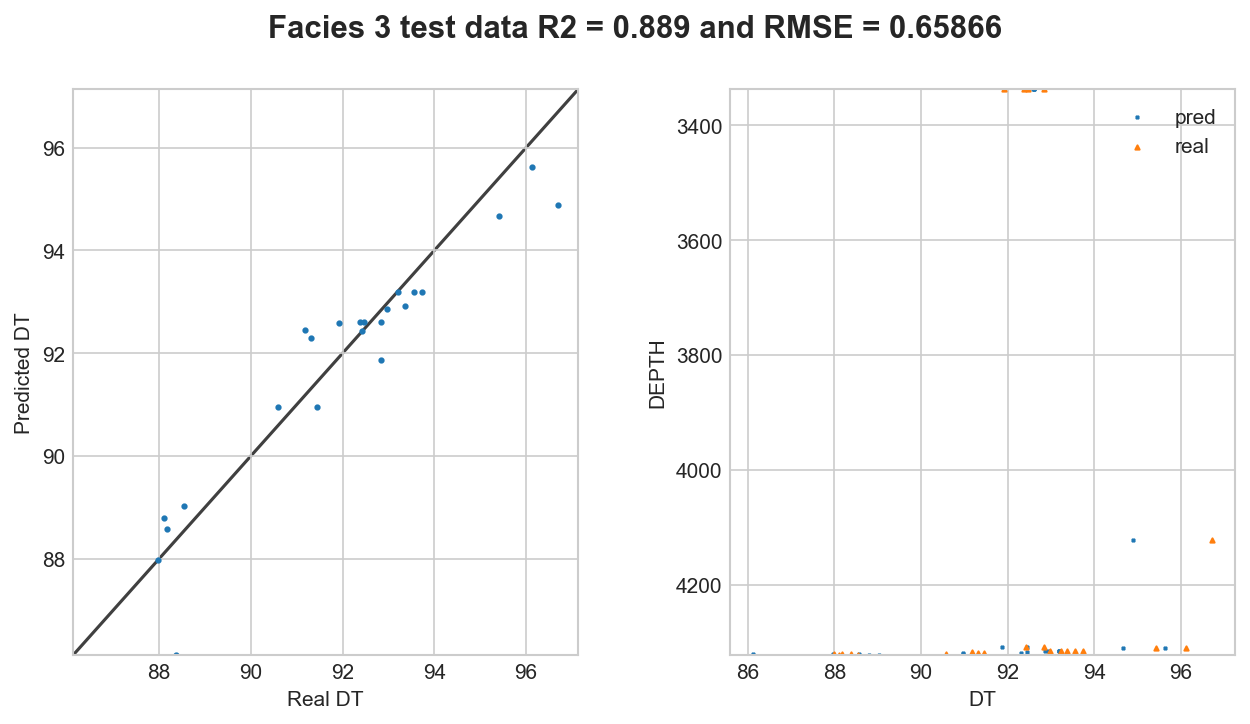

In [396]:
# Split dataset into target and attributes
# arrays for saving predictions
#Y_pred_DT=np.repeat(np.zeros(DT_blind.shape[0]),2).reshape((-1, 2))
Y_pred_DT=np.zeros(DT_blind.shape[0])
name='DT'
for i in DT['Facies'].unique():
    DT_split=DT[DT.Facies.values==i].copy()
    target = DT_split[['DEPTH', 'DT']]
    target.set_index('DEPTH', inplace=True)
    attributes = DT_split.drop(['WELL_NAME', 'DEPTH', 'DT', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    DT_blind_split=DT_blind[DT_blind.Facies.values==i].copy()
    Y_blind = DT_blind_split[['DEPTH', 'DT']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = DT_blind_split.drop(['WELL_NAME', 'DEPTH', 'DT', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_DT[DT_blind.Facies.values==i]=Y_blind_pred
    
Y_test_DT=DT_blind['DT'].values

Text(0.5, 1.0, 'R2 = 0.785 and RMSE = 30.10841')

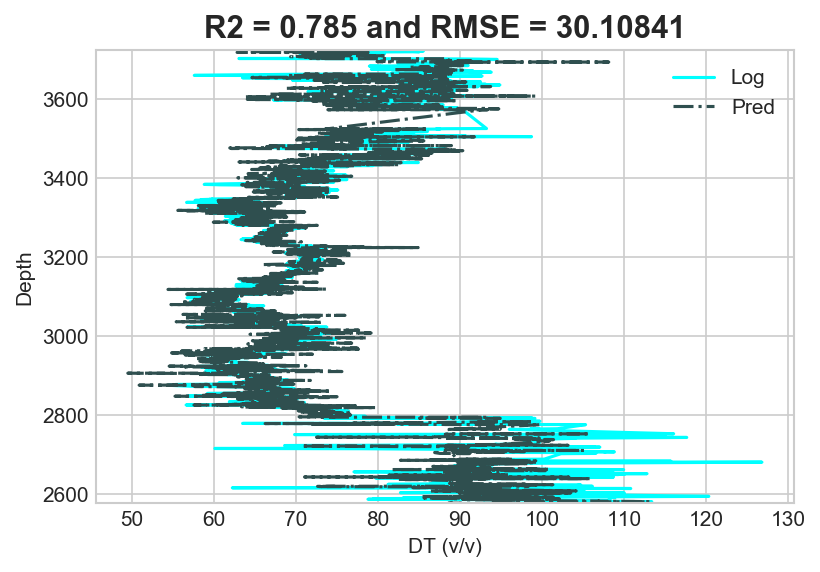

In [397]:
#test the accuracy
mse = mean_squared_error(Y_test_DT, Y_pred_DT)
r2 = r2_score(Y_test_DT, Y_pred_DT)

plt.plot(Y_test_DT, DT_blind.DEPTH, c='cyan')
plt.plot(Y_pred_DT, DT_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.xlabel('DT (v/v)')
#plt.xlim(0,1) 
plt.ylim(np.min(DT_blind.DEPTH),np.max(DT_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)

### DTS Prediction

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119180 entries, 36157 to 359425
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  119180 non-null  object 
 1   DEPTH      119180 non-null  float64
 2   GR         119180 non-null  float64
 3   CALI       119180 non-null  float64
 4   RHOB       119180 non-null  float64
 5   NPHI       119180 non-null  float64
 6   PEF        111629 non-null  float64
 7   DTS        42812 non-null   float64
 8   Facies     119180 non-null  int32  
dtypes: float64(7), int32(1), object(1)
memory usage: 13.6+ MB
None
Before anomaly treatment
                  GR          CALI          RHOB          NPHI           PEF  \
count  42812.000000  42812.000000  42812.000000  42812.000000  42812.000000   
mean      34.318402      8.652205      2.489143      0.156701      7.328544   
std       45.230072      0.056168      0.134222      0.089918      1.195515   
min        1.812000      

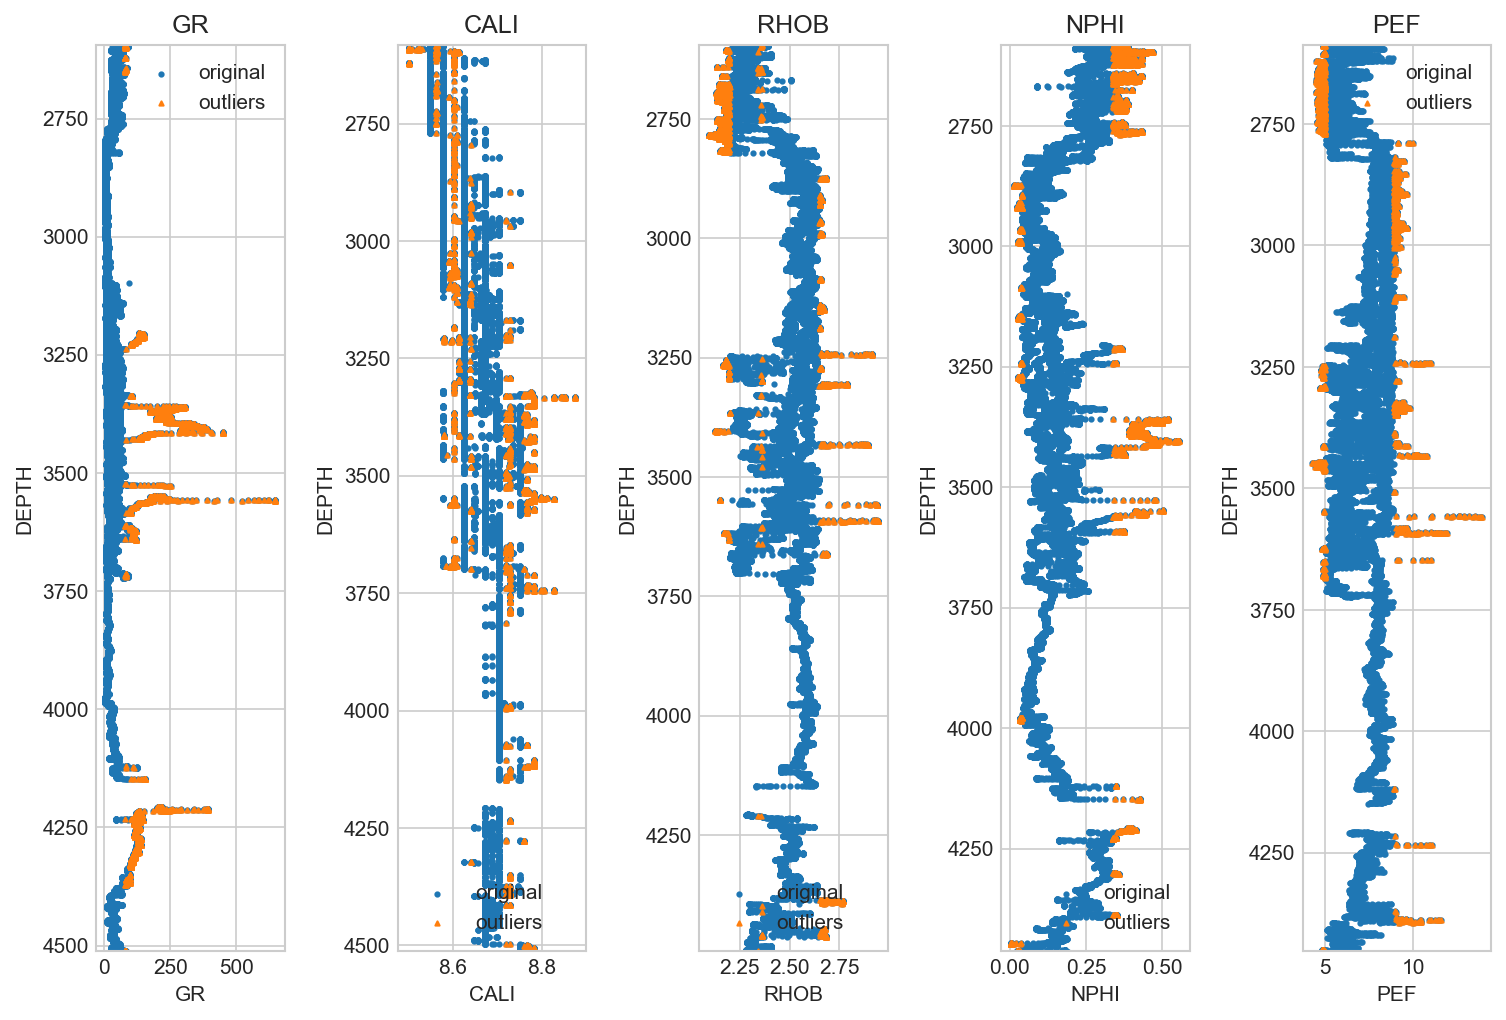

In [399]:
DTS = dfm.drop(['BS', 'ROP', 'RM', 'RD', 'DT', 'VCARB', 'VSH', 'PHIF', 'SW',# 'PEF',
                  'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1) 
print(DTS.info())
# drop all nan values from VShale data
DTS.dropna(inplace=True)
DTS.shape

DTS_df=outlier_removal(DTS, ind=-2)

Text(0.5, 1, 'DTS correlation')

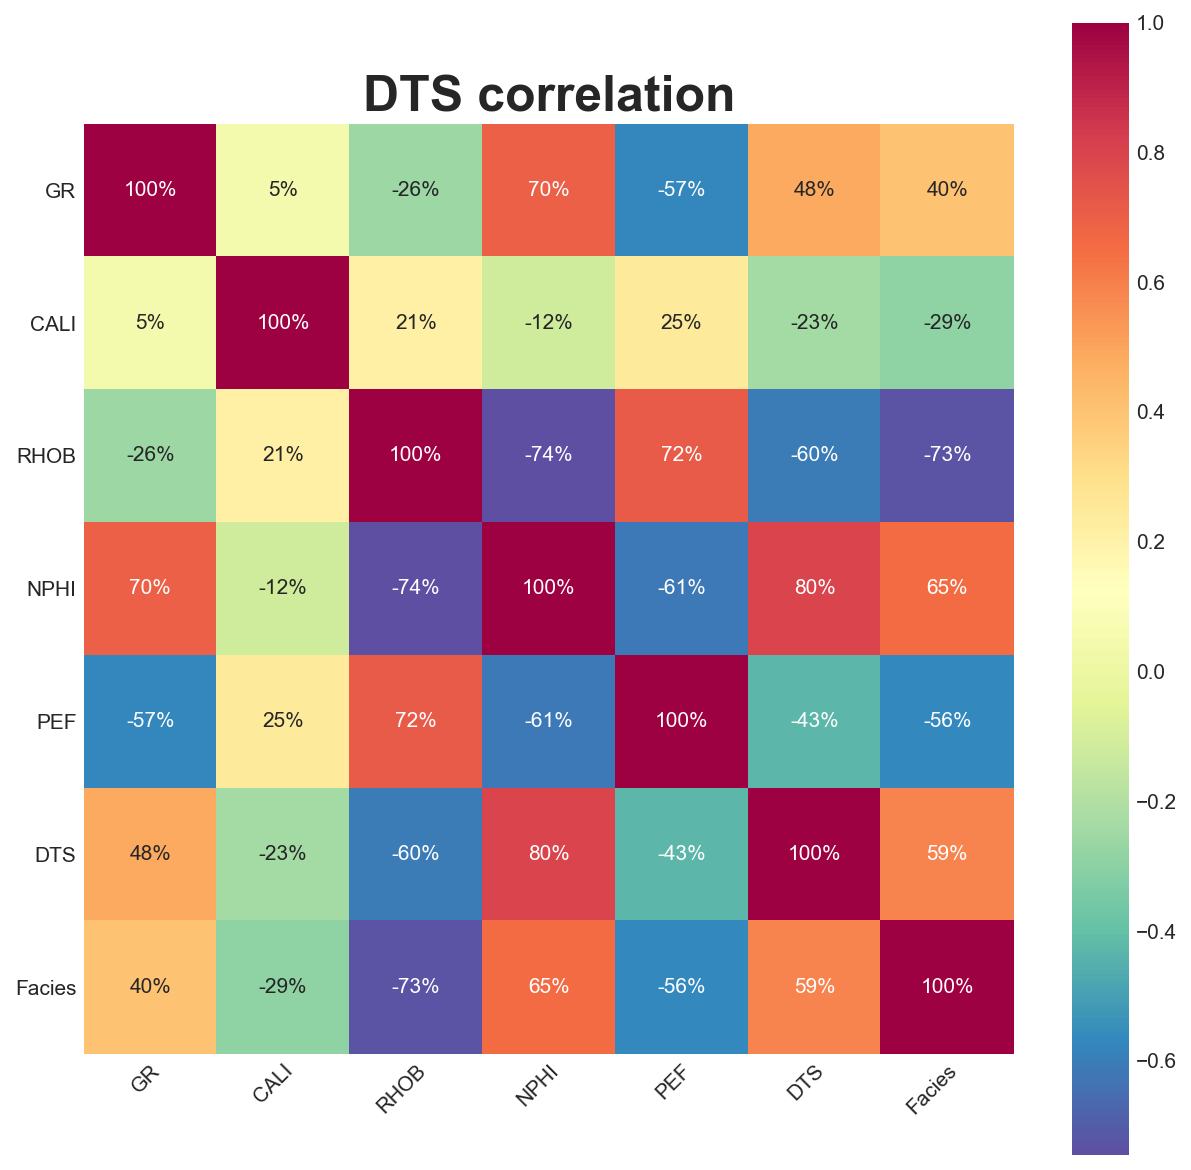

In [402]:
# Visualize correlation
data_scaled = DataFrame(Prescale.fit_transform(DTS_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=DTS_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=DTS_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('DTS correlation',weight='bold', fontsize=24)

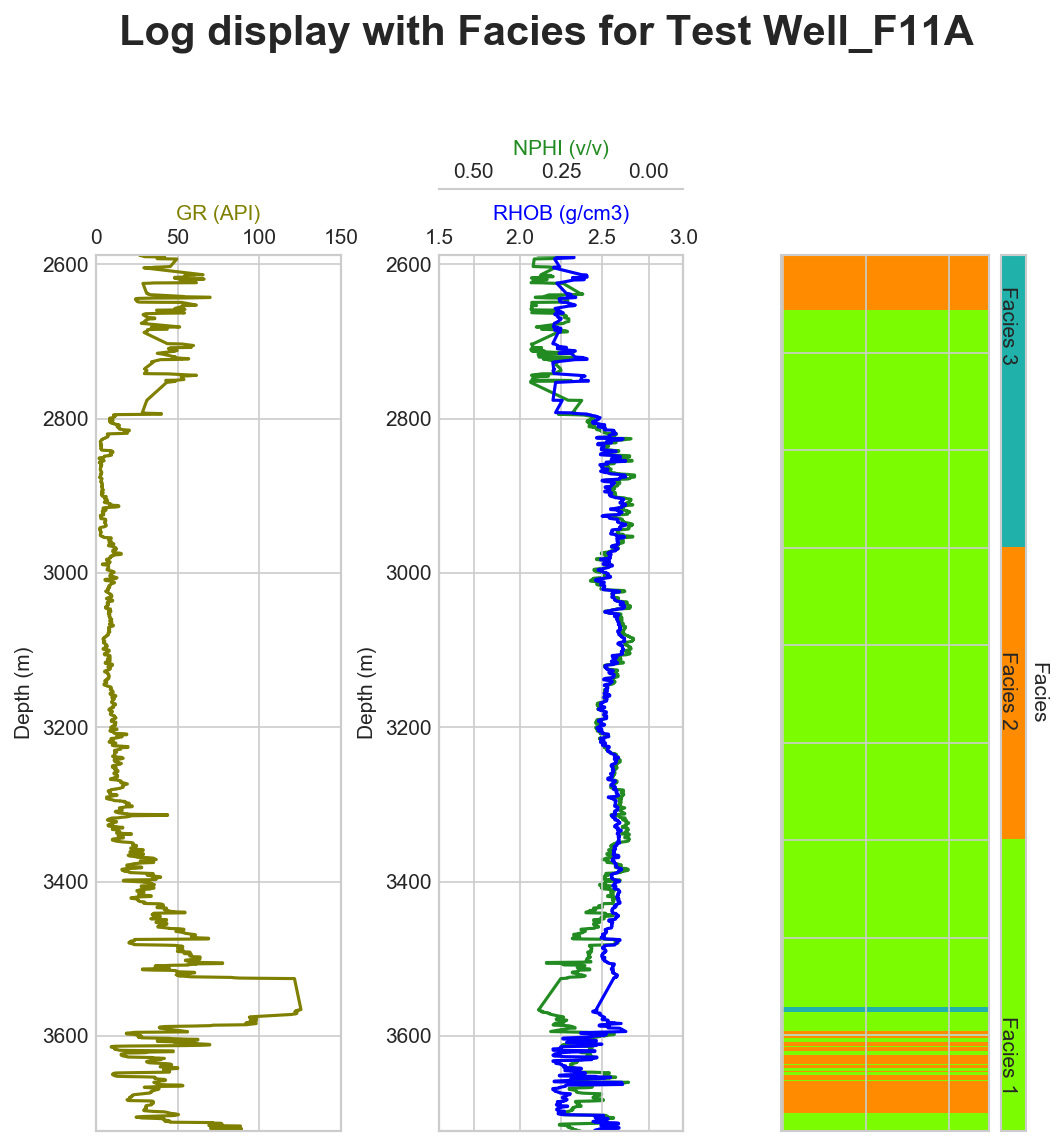

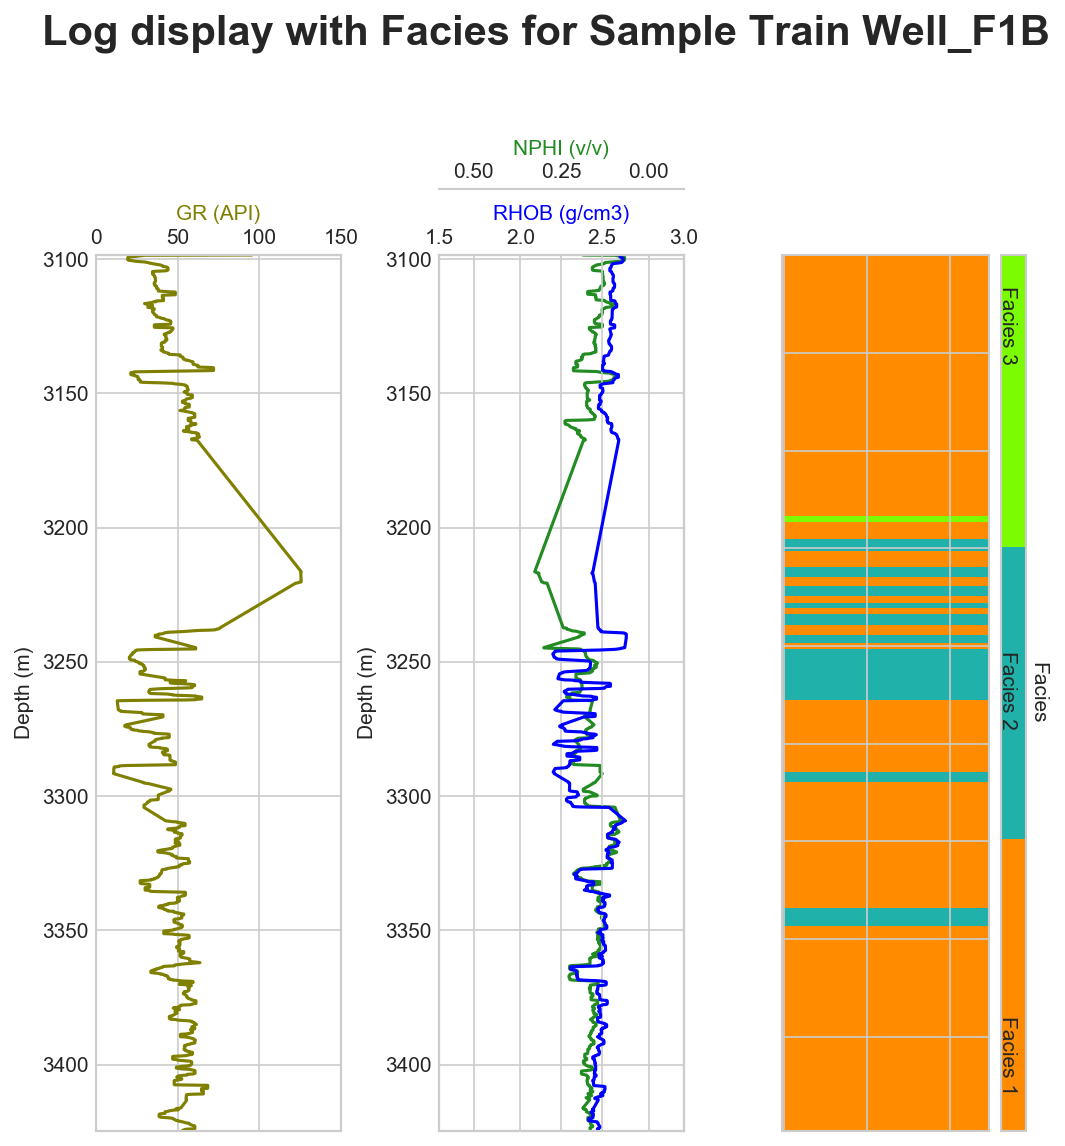

In [403]:
# create blind test data with Well_F11A
DTS_blind = DTS_df[DTS_df['WELL_NAME'] == 'Well_F11A']
DTS = DTS_df[DTS_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
log_plot (DTS_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (DTS[DTS['WELL_NAME'] == 'Well_F1B'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

Before applying noise-filter [DTS]
                 GR         CALI         RHOB        NPHI          PEF
count  2463.000000  2463.000000  2463.000000  2463.00000  2463.000000
mean     35.940919     8.605315     2.290741     0.22695     5.633677
std      12.320390     0.047684     0.063367     0.04221     0.566131
min       7.801400     8.546900     2.198000     0.09000     5.013300
25%      27.606000     8.578000     2.237000     0.19340     5.275000
50%      33.356000     8.578100     2.287000     0.22320     5.465000
75%      44.073500     8.663700     2.326700     0.25100     5.759200
max      95.859800     8.703200     2.518600     0.33700     8.791000
After applying noise-filter [DTS]
                 GR         CALI         RHOB         NPHI          PEF
count  2463.000000  2463.000000  2463.000000  2463.000000  2463.000000
mean     36.031103     8.605344     2.291958     0.227624     5.626020
std      11.600935     0.047430     0.060746     0.040941     0.511509
min      10.975

No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: 0.913962 using {'C': 100.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1     0.913962  0.015300    {'C': 100.0, 'gamma': 0.6309573444801936}
2     0.885615  0.030134    {'C': 100.0, 'gamma': 15.848931924611133}
3     0.822276  0.0

No handles with labels found to put in legend.


{'C': 100.0, 'gamma': 15.848931924611133}
Before applying noise-filter [DTS]
                 GR         CALI         RHOB         NPHI          PEF
count  7715.000000  7715.000000  7715.000000  7715.000000  7715.000000
mean     18.802377     8.647850     2.555251     0.114469     7.951028
std      18.489925     0.031723     0.048175     0.043808     0.625500
min       1.812000     8.578000     2.336000     0.040000     5.086000
25%       7.518000     8.625000     2.521000     0.083000     7.757000
50%      10.591000     8.625000     2.564000     0.107000     8.154000
75%      24.410000     8.672000     2.592000     0.135000     8.362000
max     121.560000     8.750000     2.647000     0.292000     8.909000
After applying noise-filter [DTS]
                 GR         CALI         RHOB         NPHI          PEF
count  7715.000000  7715.000000  7715.000000  7715.000000  7715.000000
mean     18.909851     8.648202     2.556018     0.114971     7.957708
std      18.502929     0.031473    

No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: 0.777923 using {'C': 100.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1     0.777923  0.126441    {'C': 100.0, 'gamma': 0.6309573444801936}
2     0.713497  0.148938     {'C': 10.0, 'gamma': 0.6309573444801936}
3     0.521573  0.2

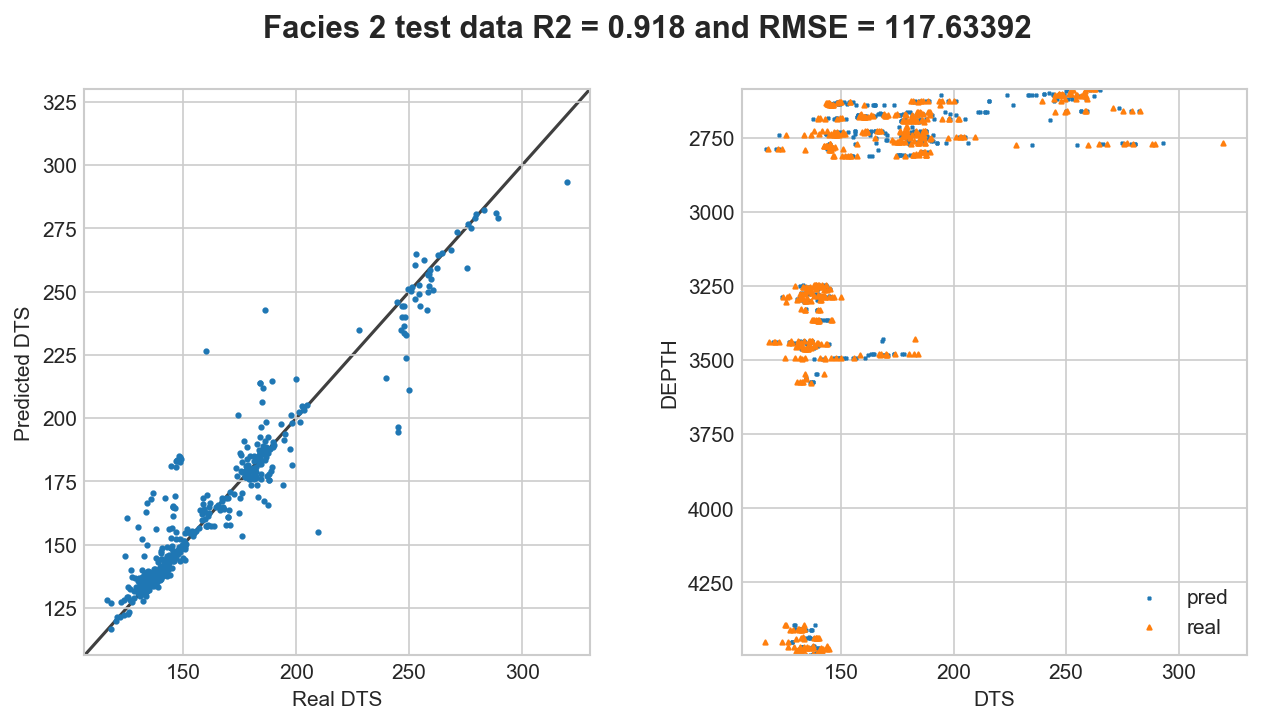

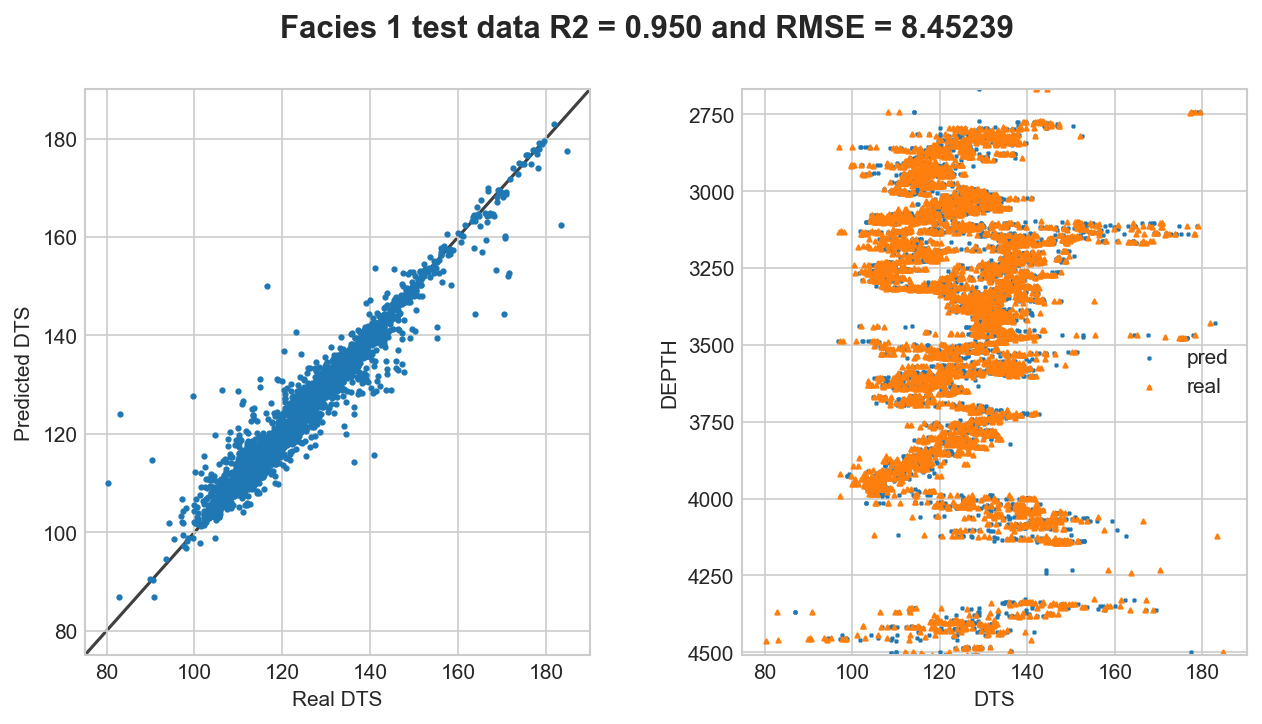

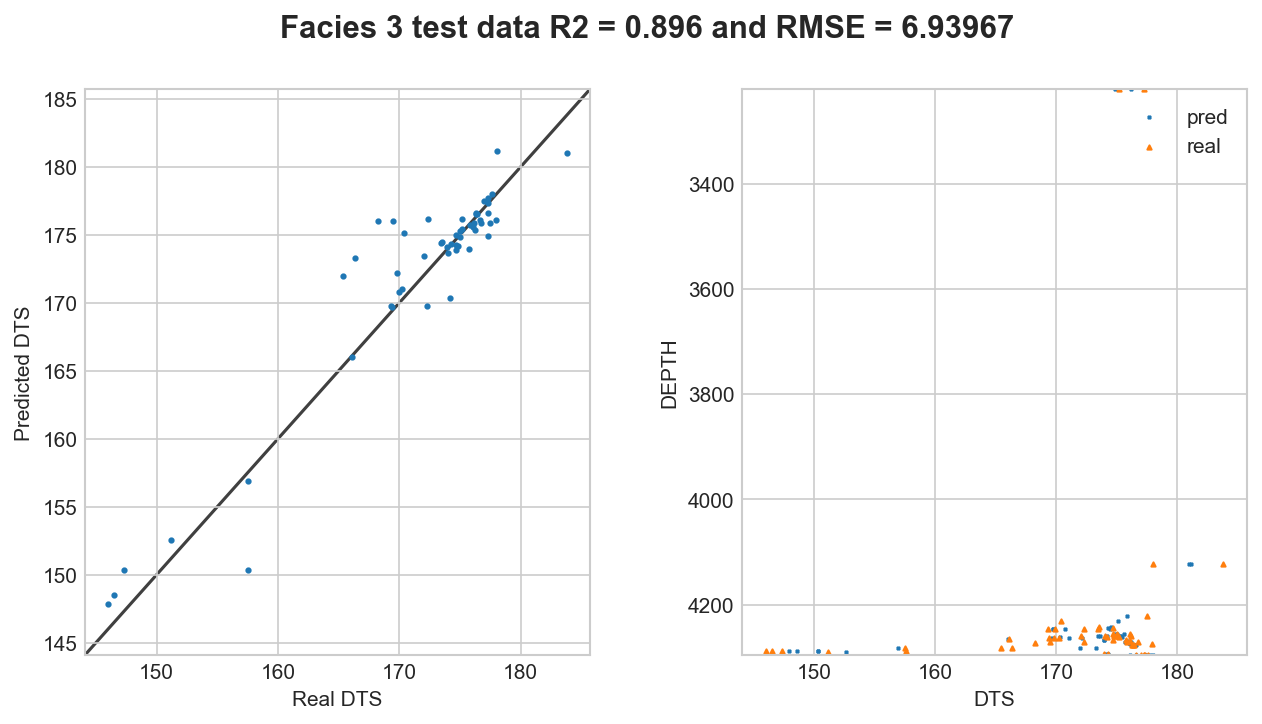

In [404]:
# Split dataset into target and attributes
# arrays for saving predictions
Y_pred_DTS=np.zeros(DTS_blind.shape[0])
name='DTS'
for i in DTS['Facies'].unique():
    DTS_split=DTS[DTS.Facies.values==i].copy()
    target = DTS_split[['DEPTH', 'DTS']]
    target.set_index('DEPTH', inplace=True)
    attributes = DTS_split.drop(['WELL_NAME', 'DEPTH', 'DTS', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    DTS_blind_split=DTS_blind[DTS_blind.Facies.values==i].copy()
    Y_blind = DTS_blind_split[['DEPTH', 'DTS']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = DTS_blind_split.drop(['WELL_NAME', 'DEPTH', 'DTS', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_DTS[DTS_blind.Facies.values==i]=Y_blind_pred
    
Y_test_DTS=DTS_blind['DTS'].values

Text(0.5, 1.0, 'R2 = 0.599 and RMSE = 340.46869')

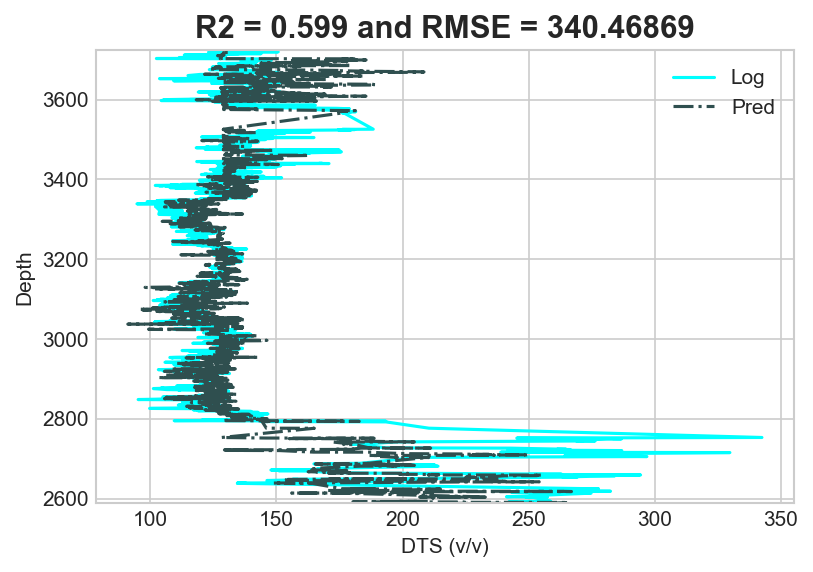

In [406]:
#test the accuracy
mse = mean_squared_error(Y_test_DTS, Y_pred_DTS)
r2 = r2_score(Y_test_DTS, Y_pred_DTS)

plt.plot(Y_test_DTS, DTS_blind.DEPTH, c='cyan')
plt.plot(Y_pred_DTS, DTS_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.xlabel('DTS (v/v)')
#plt.xlim(0,1) 
plt.ylim(np.min(DTS_blind.DEPTH),np.max(DTS_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)

### PORO Prediction

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348110 entries, 0 to 359591
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  348110 non-null  object 
 1   DEPTH      348110 non-null  float64
 2   GR         345801 non-null  float64
 3   RHOB       160609 non-null  float64
 4   NPHI       143927 non-null  float64
 5   PHIF       81516 non-null   float64
dtypes: float64(5), object(1)
memory usage: 18.6+ MB
None
Before anomaly treatment
                  GR          RHOB          NPHI          PHIF
count  81471.000000  81471.000000  81471.000000  81471.000000
mean      45.269673      2.411504      0.184874      0.141086
std       38.624963      0.157998      0.070716      0.081239
min        2.675900      1.387600     -0.003000      0.000000
25%       21.907950      2.264300      0.143200      0.066800
50%       36.741100      2.430000      0.178800      0.134500
75%       56.437550      2.546000      0.217

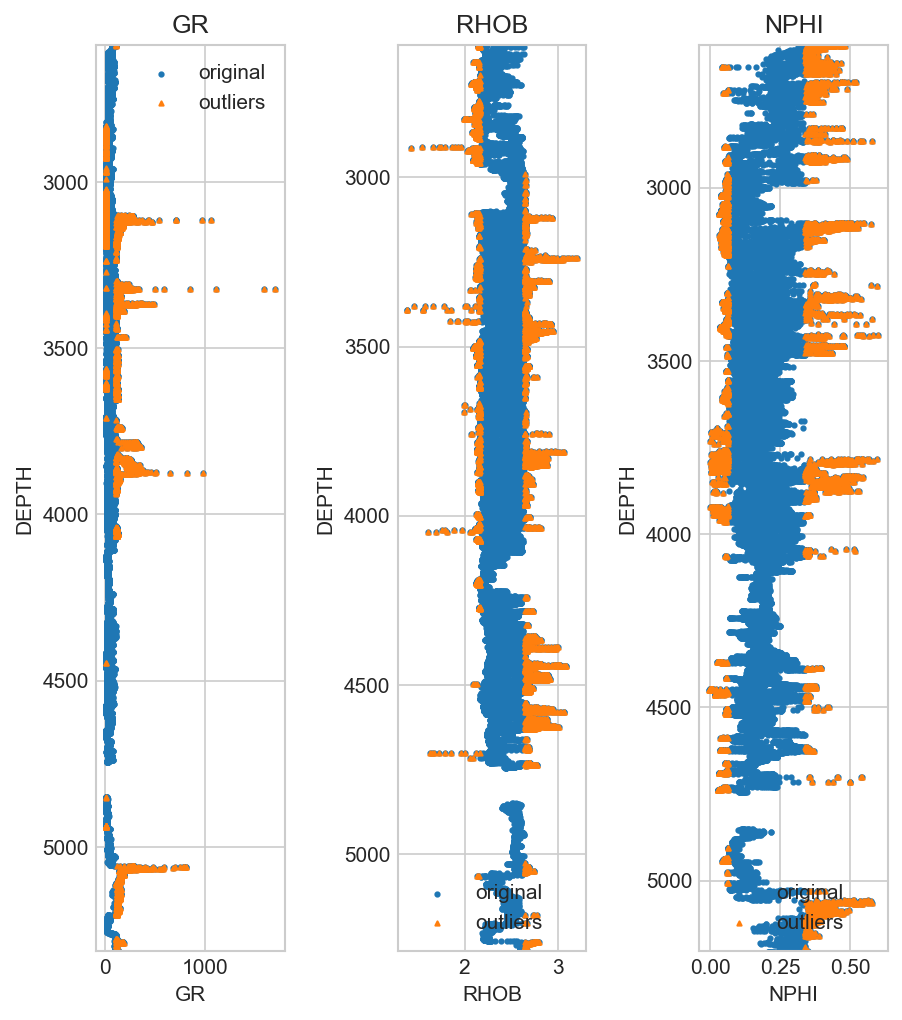

In [278]:
POR = dfm.drop(['BS', 'ROP', 'RM', 'RD', 'PEF', 'DT', 'DTS', 'VCARB', 'VSH', 'SW', 'CALI',
                  'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1) 
print(POR.info())
# drop all nan values from data
POR.dropna(inplace=True)
POR.shape

POR_df=outlier_removal(POR, ind=-1)

Text(0.5, 1, 'DT correlation')

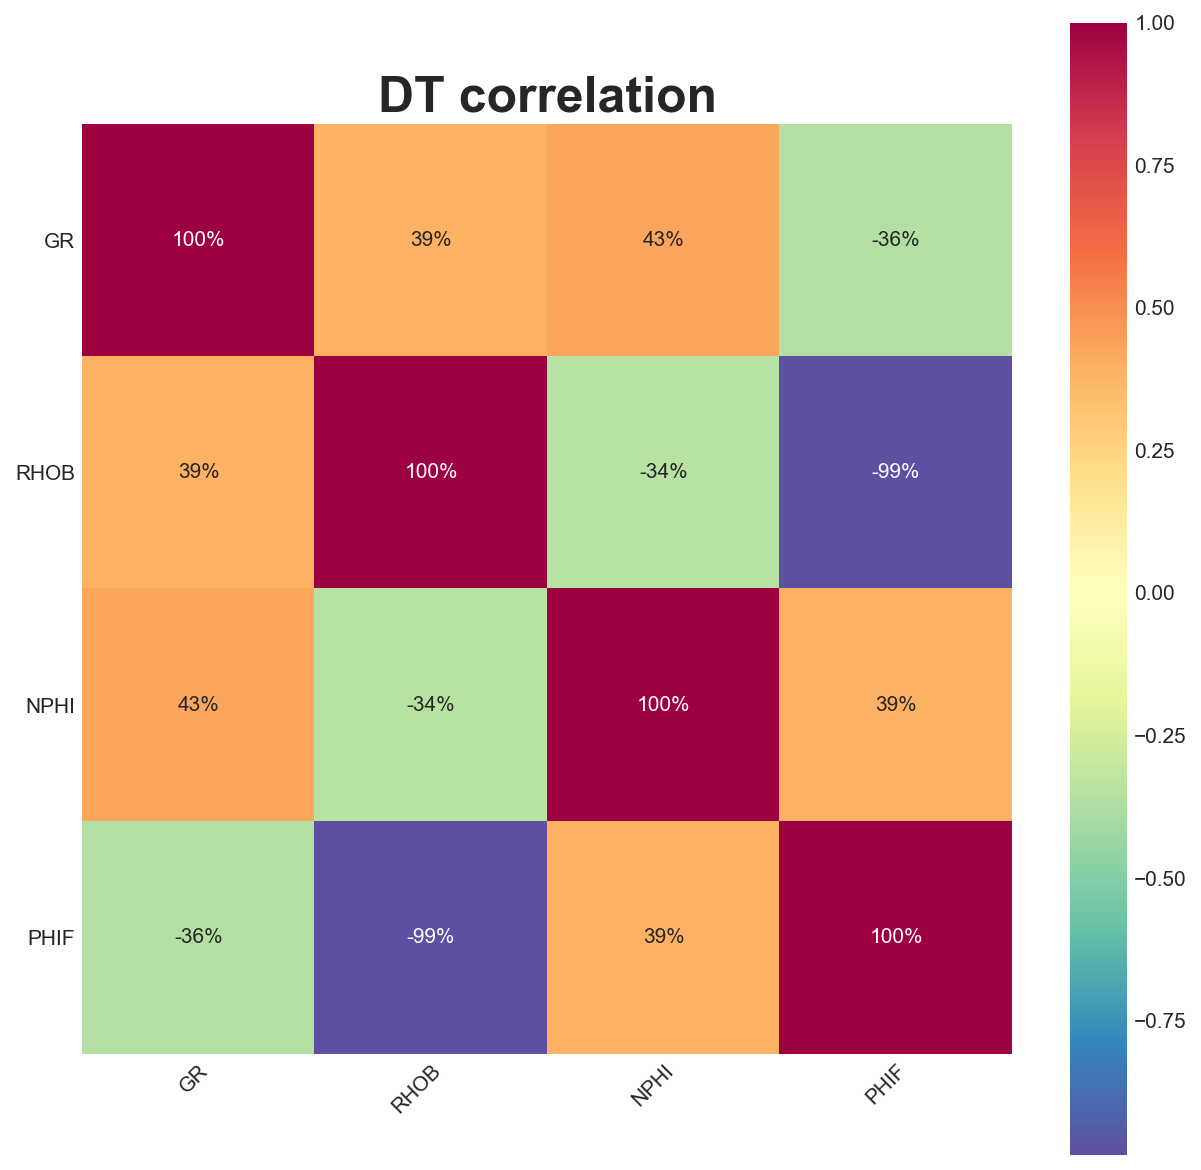

In [279]:
# Visualize correlation
data_scaled = DataFrame(Prescale.fit_transform(POR_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=POR_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=POR_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('PHIF correlation',weight='bold', fontsize=24)

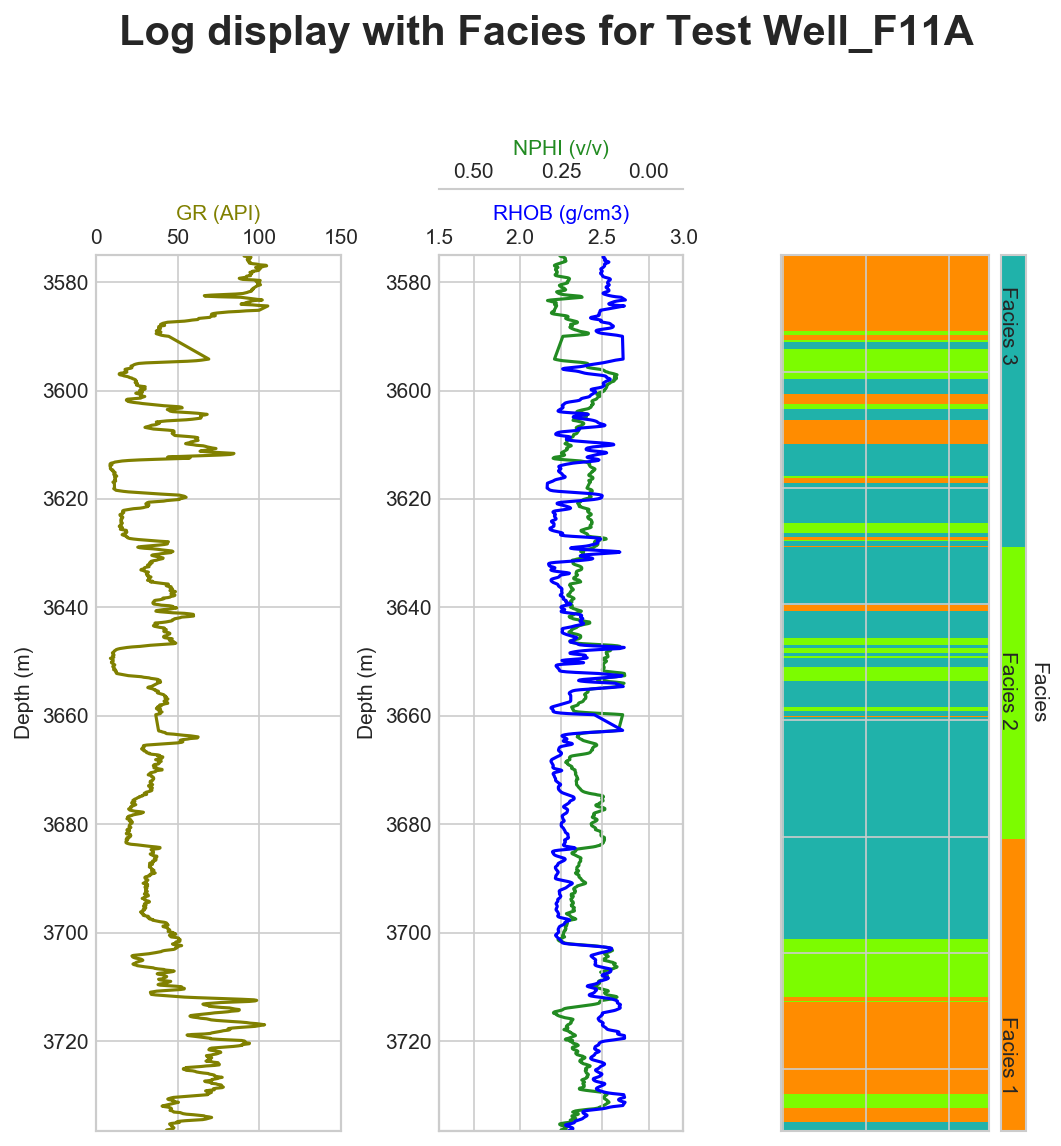

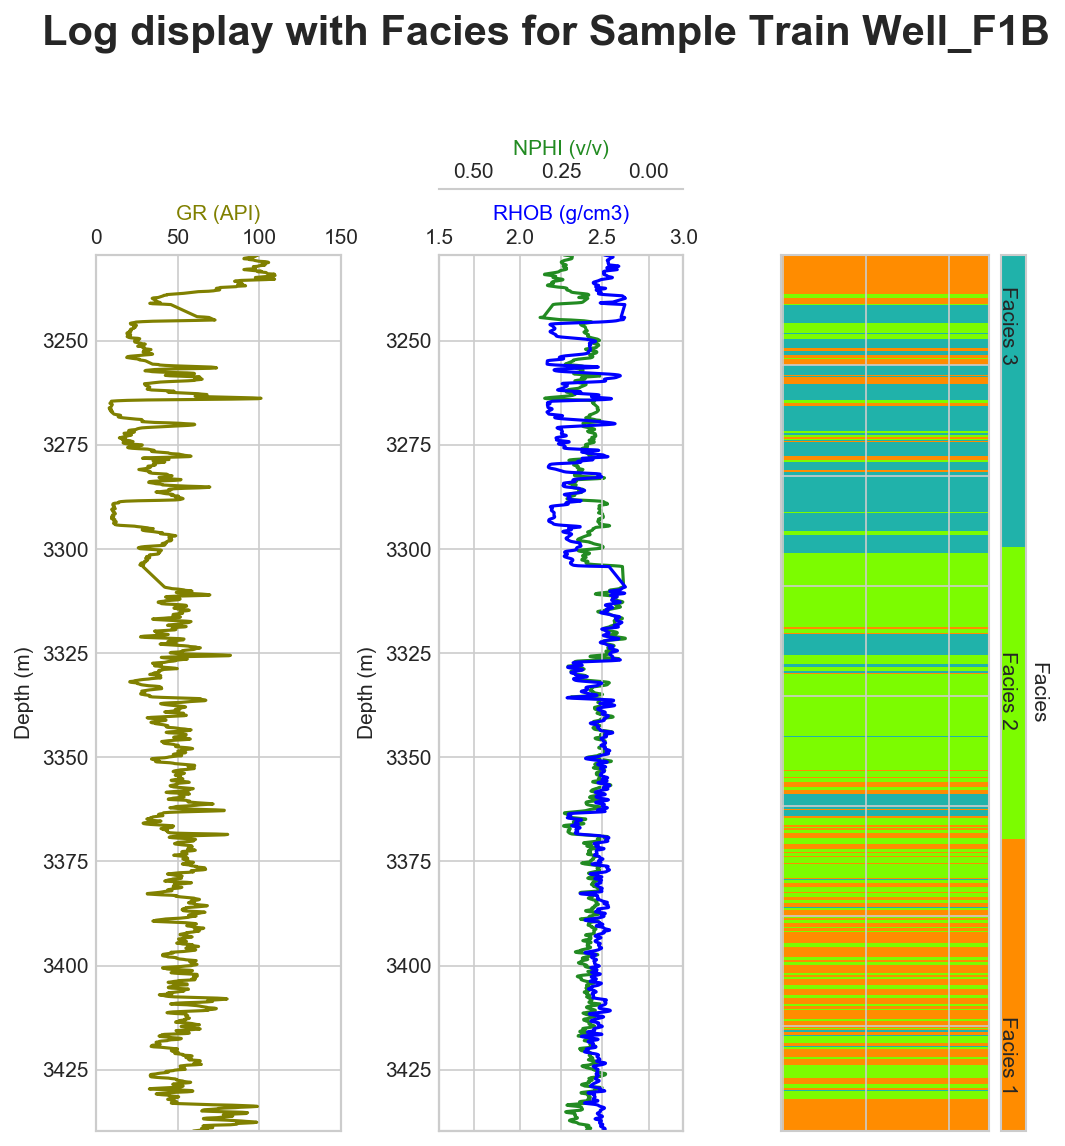

In [281]:
# create blind test data with Well_F11A
POR_blind = POR_df[POR_df['WELL_NAME'] == 'Well_F11A']
POR = POR_df[POR_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
log_plot (POR_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (POR[POR['WELL_NAME'] == 'Well_F1B'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

After applying noise-filter
                  GR          RHOB          NPHI
count  28588.000000  28588.000000  28588.000000
mean      27.127898      2.258622      0.191484
std       10.901414      0.058001      0.030686
min        8.043200      2.166700      0.127900
25%       17.631175      2.210000      0.166000
50%       26.660900      2.250900      0.190800
75%       34.624000      2.298100      0.211000
max       63.265499      2.454000      0.310369


No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: -1.081832 using {'C': 10.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1    -1.081832  0.096193     {'C': 10.0, 'gamma': 0.6309573444801936}
2    -1.609243  0.250505    {'C': 100.0, 'gamma': 0.6309573444801936}
3    -1.621400  0.1

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Attempting to set identical bottom == top == 0.09389450299739838 results in singular transformations; automatically expanding.
No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: -0.201387 using {'C': 1.0, 'gamma': 0.001}
         means     stdev                                       params
rank                                                                 
1    -0.201387  0.034428                   {'C': 1.0, 'gamma': 0.001}
1    -0.201387  0.034428    {'C': 1.0, 'gamma': 0.025118864315095808}
1    -0.201387  0.034428      {'C

No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: 0.521516 using {'C': 10.0, 'gamma': 0.025118864315095808}
         means     stdev                                       params
rank                                                                 
1     0.521516  0.028193   {'C': 10.0, 'gamma': 0.025118864315095808}
2     0.500880  0.016960                 {'C': 100.0, 'gamma': 0.001}
3     0.475755  0.

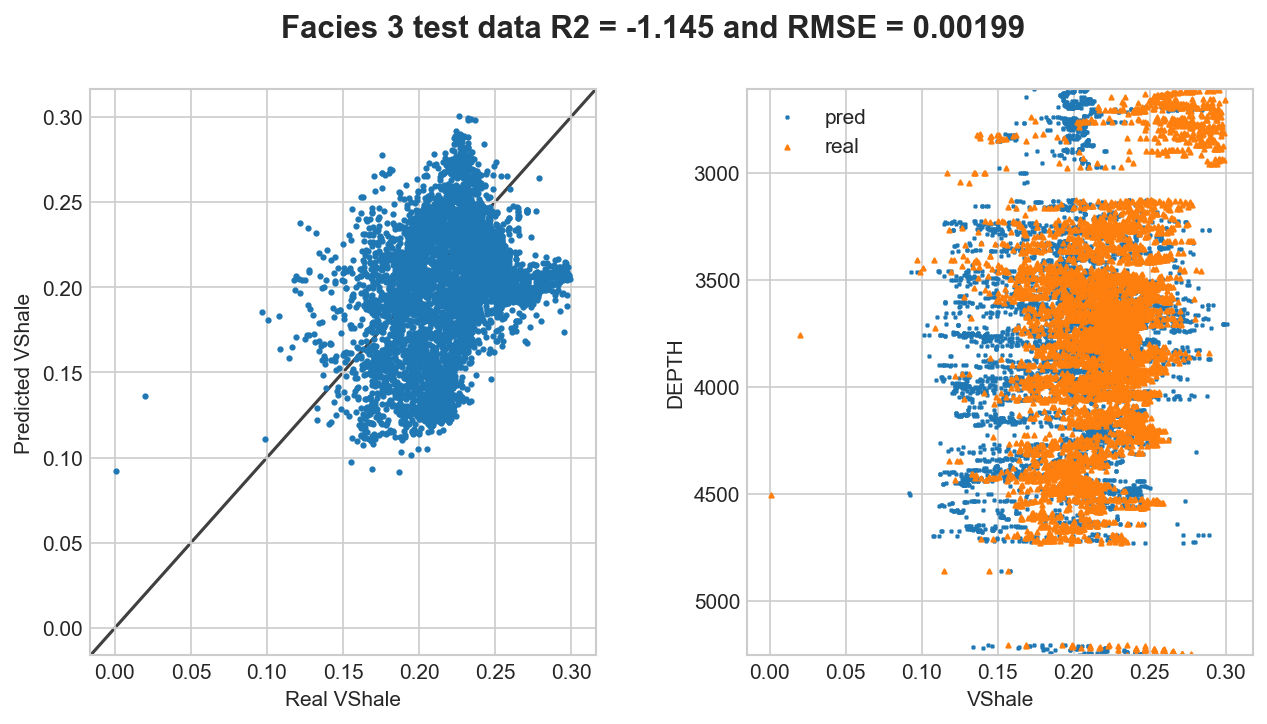

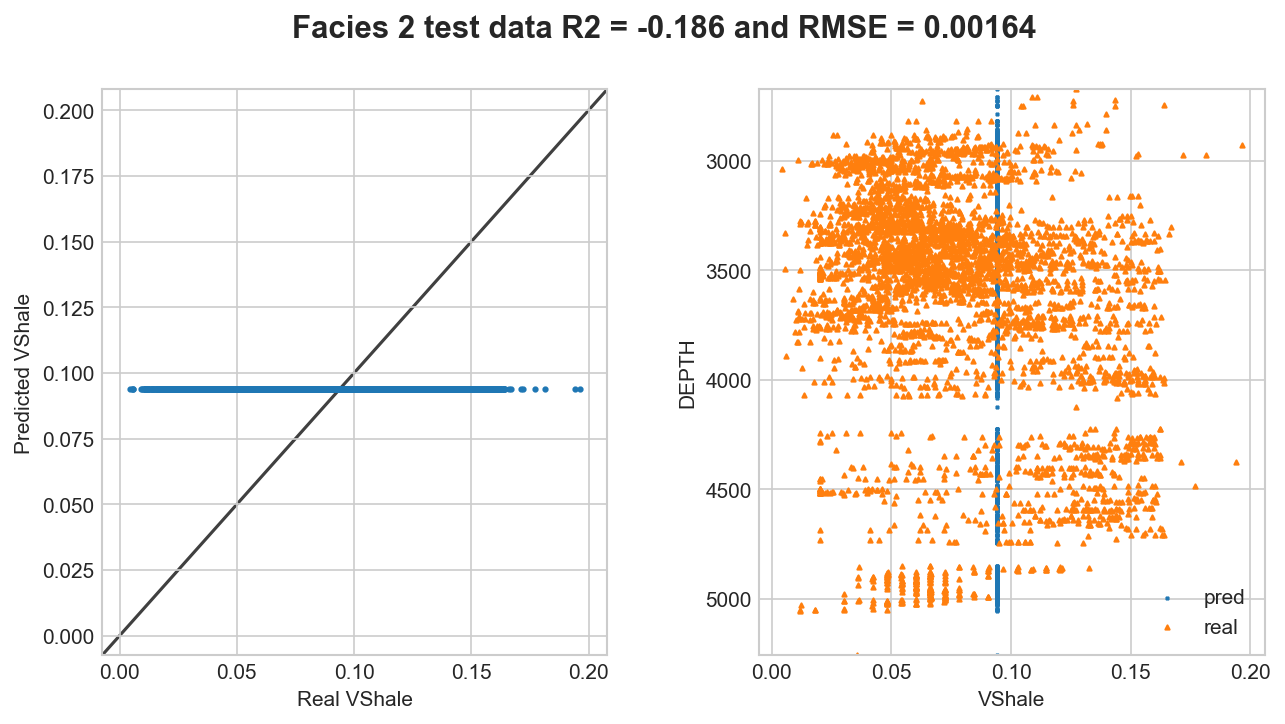

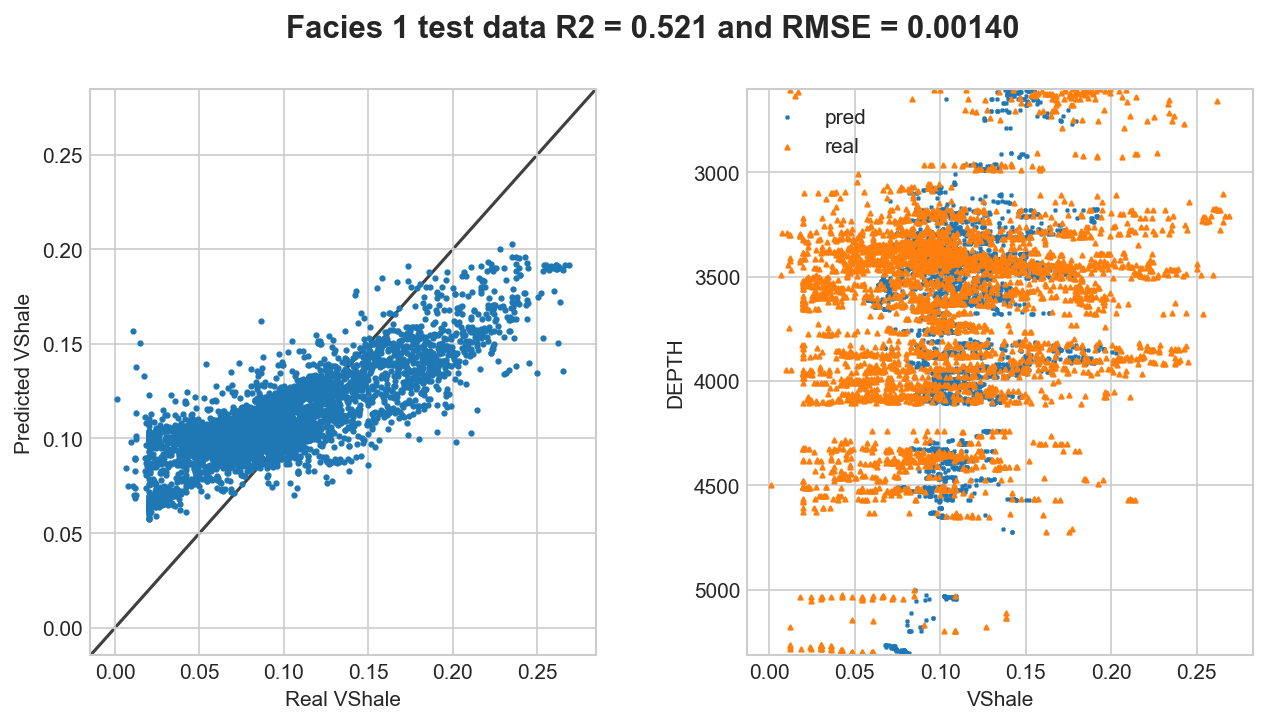

In [282]:
# Split dataset into target and attributes
# arrays for saving predictions
Y_pred_POR=np.zeros(POR_blind.shape[0])
name='PHIF'
for i in POR['Facies'].unique():
    POR_split=POR[POR.Facies.values==i].copy()
    target = POR_split[['DEPTH', 'PHIF']]
    target.set_index('DEPTH', inplace=True)
    attributes = POR_split.drop(['WELL_NAME', 'DEPTH', 'PHIF', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    POR_blind_split=POR_blind[POR_blind.Facies.values==i].copy()
    Y_blind = POR_blind_split[['DEPTH', 'PHIF']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = POR_blind_split.drop(['WELL_NAME', 'DEPTH', 'PHIF', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_POR[POR_blind.Facies.values==i]=Y_blind_pred
    
Y_test_POR=POR_blind['PHIF'].values

Text(0.5, 1.0, 'R2 = 0.605 and RMSE = 0.00186')

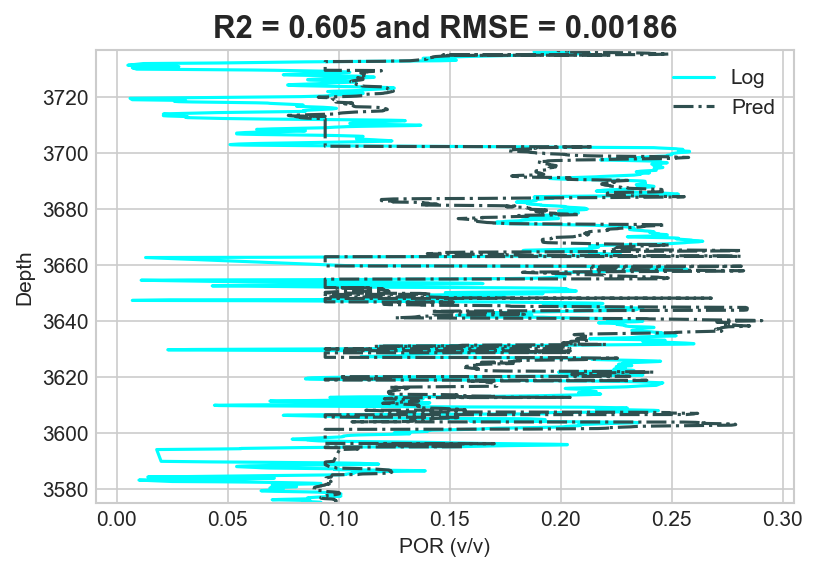

In [283]:
#test the accuracy
mse = mean_squared_error(Y_test_POR, Y_pred_POR)
r2 = r2_score(Y_test_POR, Y_pred_POR)

plt.plot(Y_test_POR, POR_blind.DEPTH, c='cyan')
plt.plot(Y_pred_POR, POR_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.xlabel('POR (v/v)')
#plt.xlim(0,1) 
plt.ylim(np.min(POR_blind.DEPTH),np.max(POR_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)